<a href="https://colab.research.google.com/github/hyeonseonn/sensing_app/blob/main/%5B0811new%5Dmachine_learning_for_disk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## disk 예측 (disk I/O와 사용률 중에서 사용률이 더 HPC 종량제에 연결 쉬움)
### 단기 디스크 사용률 (초단위) 은 onTune에서 한달치만 저장 가능
### 한 달 평균치를 모아서 1년 치 생성
### 주간에 활동하는 disk 가정


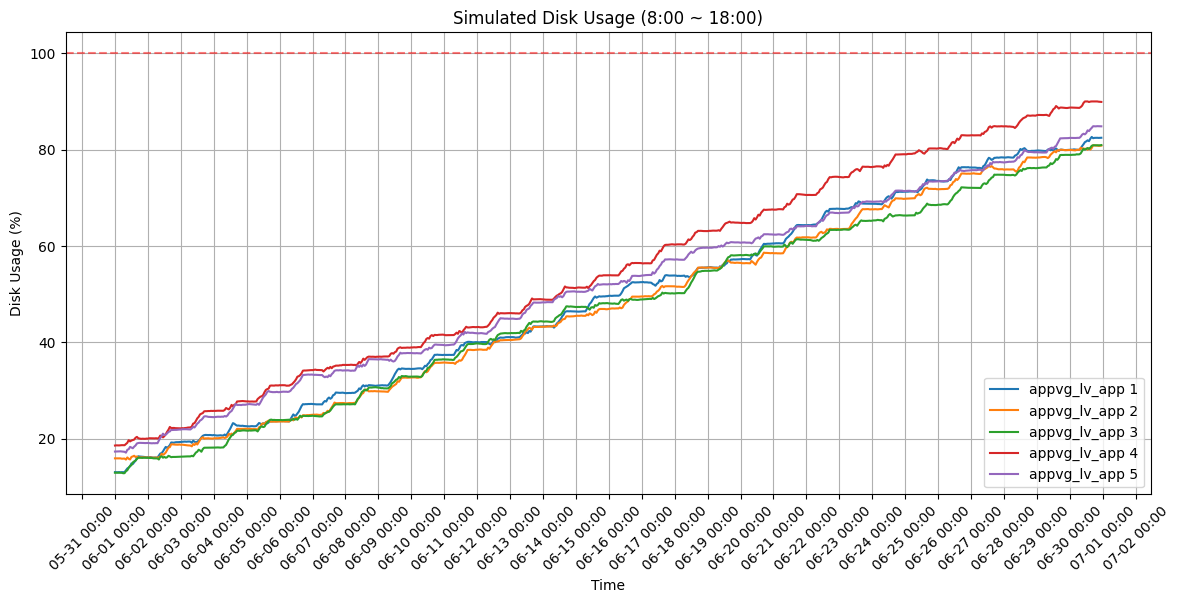

In [1]:
# 한달 동안의 디스크 사용량

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta

# 시뮬레이션 설정
days = 30
hours_per_day = 24
total_steps = days * hours_per_day

# 시작 날짜 설정
start_time = datetime(2025, 6, 1, 0, 0)
time_datetimes = [start_time + timedelta(hours=i) for i in range(total_steps)]

n_disks = 5
disk_usage = np.zeros((n_disks, total_steps))
initial_usage = np.random.uniform(10, 20, size=n_disks)

work_hours = list(range(8, 18))

for d in range(n_disks):
    usage = initial_usage[d]
    for t in range(total_steps):
        current_hour = t % 24
        if current_hour in work_hours:
            if np.random.rand() < 0.8:
                usage += np.random.uniform(0.08, 0.6)
            else:
                usage -= np.random.uniform(0.1, 0.3)
        else:
            usage += np.random.normal(0, 0.03)
        usage = min(usage, 90)
        disk_usage[d, t] = usage

# 시각화
plt.figure(figsize=(14, 6))
for d in range(n_disks):
    plt.plot(time_datetimes, disk_usage[d], label=f'appvg_lv_app {d+1}')

plt.xlabel("Time")
plt.ylabel("Disk Usage (%)")
plt.title("Simulated Disk Usage (8:00 ~ 18:00)")

# ✅ x축 날짜 포맷 설정
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))  # 2일 간격
plt.xticks(rotation=45)

plt.axhline(100, color='red', linestyle='--', alpha=0.5)
plt.legend()
plt.grid(True)

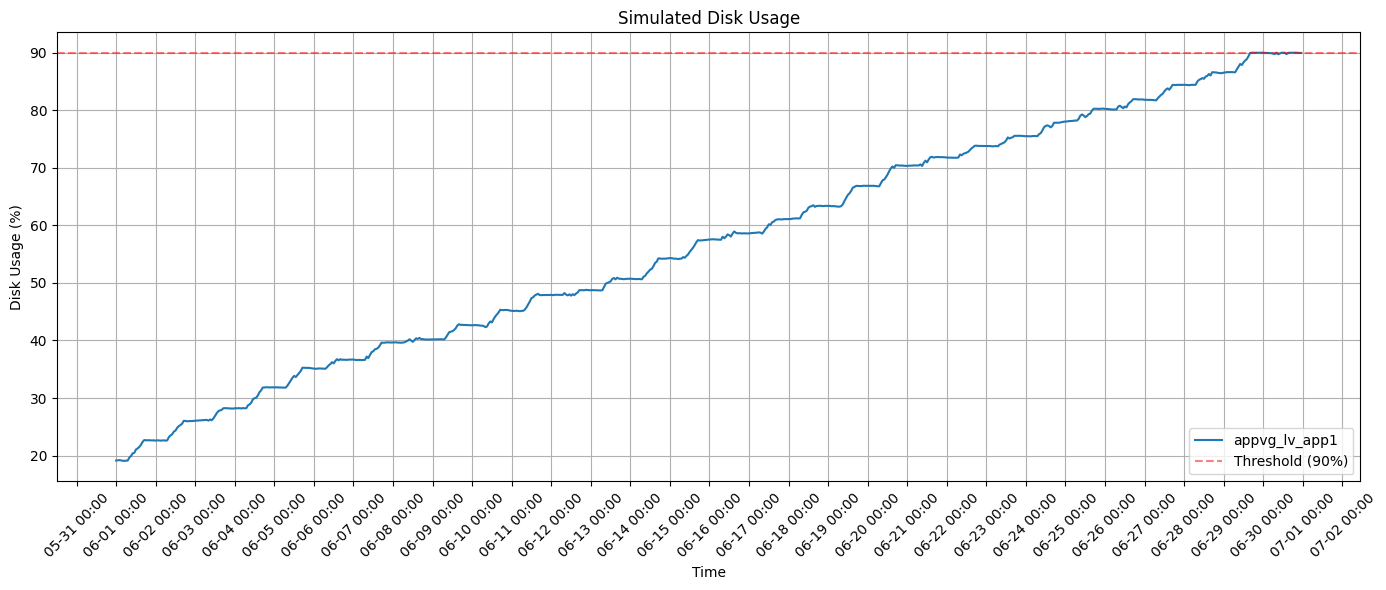

In [2]:
# 한달 동안의 단일 디스크 사용량 (1개 디스크)
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta

# 시뮬레이션 설정
days = 30
hours_per_day = 24
total_steps = days * hours_per_day

# 시작 날짜
start_time = datetime(2025, 6, 1, 0, 0)
time_datetimes = [start_time + timedelta(hours=i) for i in range(total_steps)]

# 단일 디스크 사용률 배열 (1D)
disk_usage = np.zeros(total_steps, dtype=float)

# 초기값 및 업무시간
usage = np.random.uniform(10, 20)     # 시작 사용률(%)
work_hours = list(range(8, 18))       # 08:00 ~ 18:00
threshold = 90                        # 상한

# 시뮬레이션
for t in range(total_steps):
    current_hour = time_datetimes[t].hour
    if current_hour in work_hours:
        if np.random.rand() < 0.8:
            usage += np.random.uniform(0.08, 0.6)   # 업무시간: 증가 위주
        else:
            usage -= np.random.uniform(0.1, 0.3)    # 가끔 하락
    else:
        usage += np.random.normal(0, 0.03)          # 비업무시간: 미세 변동
    usage = max(0.0, min(usage, threshold))         # 0~threshold로 클램프
    disk_usage[t] = usage

# 시각화
plt.figure(figsize=(14, 6))
plt.plot(time_datetimes, disk_usage, label='appvg_lv_app1')
plt.xlabel("Time")
plt.ylabel("Disk Usage (%)")
plt.title("Simulated Disk Usage")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))  # 1일 간격
plt.xticks(rotation=45)
plt.axhline(threshold, color='red', linestyle='--', alpha=0.5, label='Threshold (90%)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# (선택) memory_usage처럼 DataFrame으로 쓰고 싶다면:
import pandas as pd
df = pd.DataFrame({'timestamp': time_datetimes, 'disk_usage': disk_usage}).set_index('timestamp')


In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

days = 30
points_per_day = 24 * 12
total_points = days * points_per_day
time_index = pd.date_range('2025-06-01', periods=total_points,  freq="1H")

scaler = MinMaxScaler()
disk_scaled =pd.DataFrame( scaler.fit_transform(df[['disk_usage']]))

past_steps = 20
future_steps = 5

# ✅ 데이터 분할 (80:10:10)
n_total = len(disk_scaled)
n_train = int(n_total * 0.8)
n_val   = int(n_total * 0.1)

disk_train = disk_scaled.iloc[:n_train]
disk_val   = disk_scaled.iloc[n_train:n_train + n_val]
disk_test  = disk_scaled.iloc[n_train + n_val:]


# 시퀀스 생성
def create_sequences(dataset, past_steps=20, future_steps=5):
    X, y = [], []
    for i in range(len(dataset) - past_steps - future_steps):
        X.append(dataset[i:i+past_steps])
        y.append(dataset[i+past_steps:i+past_steps+future_steps])
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(disk_train, past_steps, future_steps)
X_val,   y_val   = create_sequences(disk_val, past_steps, future_steps)
X_test,  y_test  = create_sequences(disk_test, past_steps, future_steps)

y_train_r = y_train.reshape(y_train.shape[0], -1).astype('float32')
y_val_r   = y_val.reshape(y_val.shape[0], -1).astype('float32')

model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(past_steps, 1)),
    MaxPooling1D(pool_size=2),
    LSTM(64, activation='relu'),
    Dense(future_steps)
])
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train.reshape((y_train.shape[0], -1)), epochs=20, batch_size=16, validation_data=(X_val, y_val_r),

pred = model.predict(X_test).reshape(-1, future_steps)
true = y_test.reshape(-1, future_steps)
pred_inv = scaler.inverse_transform(pred)
true_inv = scaler.inverse_transform(true)

print("MAE :", mean_absolute_error(true_inv, pred_inv))
print("RMSE:", np.sqrt(mean_squared_error(true_inv, pred_inv)))
print("R²  :", r2_score(true_inv, pred_inv))


/tmp/ipython-input-450442481.py:12: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_index = pd.date_range('2025-06-01', periods=total_points,  freq="1H")


Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 88ms/step - loss: 0.0265 - val_loss: 0.0106
Epoch 2/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0114 - val_loss: 0.0020
Epoch 3/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0127 - val_loss: 0.0143
Epoch 4/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0118 - val_loss: 0.0077
Epoch 5/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0103 - val_loss: 0.0064
Epoch 6/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0094 - val_loss: 0.0072
Epoch 7/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0081 - val_loss: 0.0031
Epoch 8/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0063 - val_loss: 0.0040
Epoch 9/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0057 - val_loss: 0.0021
Epoch 10/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0043 - val_loss: 3.7892e-04
Epoch 11/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0038 - val_loss: 6.7572e-04
Epoch 12/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0039 - val_loss

CNN-LSTM
MAE : 0.9994632643534803
RMSE: 1.2994846712559591
R2: -0.5395929991581928


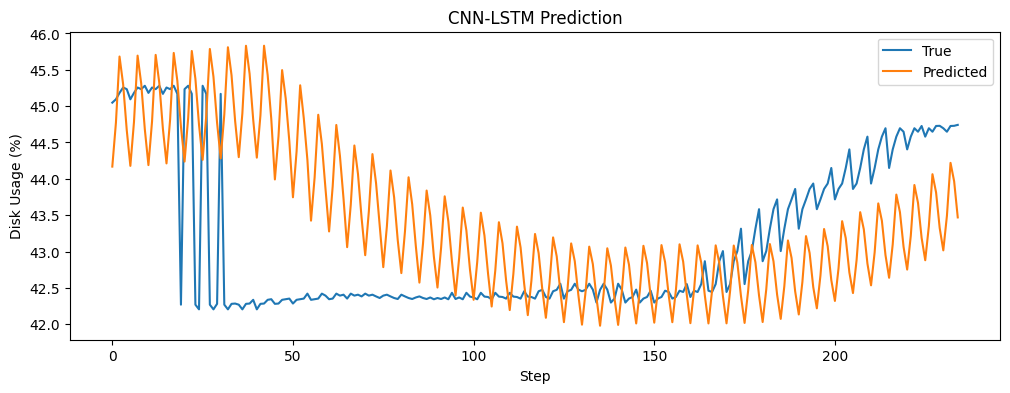

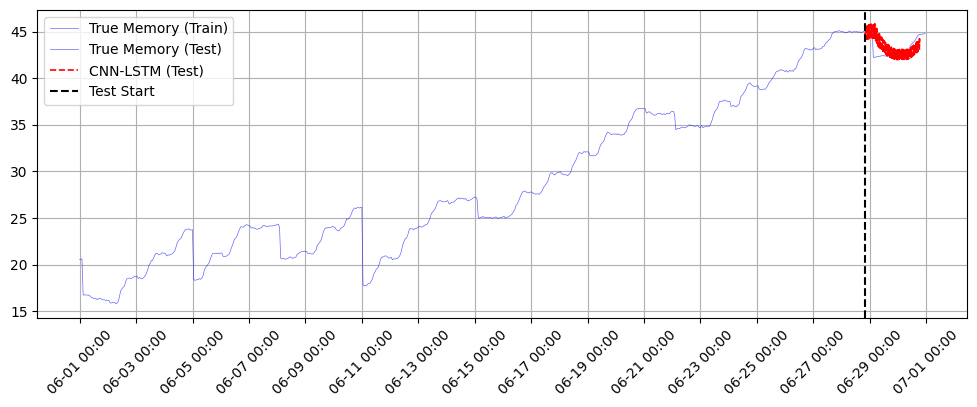

In [22]:
# plot

print("CNN-LSTM")
print("MAE :", mean_absolute_error(true_inv, pred_inv))
print("RMSE:", np.sqrt(mean_squared_error(true_inv, pred_inv)))
print("R2:", r2_score(true_inv, pred_inv))

metrics = {
    "MAE": round(mean_absolute_error(true_inv, pred_inv), 2),
    "RMSE": round(np.sqrt(mean_squared_error(true_inv, pred_inv)), 2),
    "R2": r2_score(true_inv, pred_inv)
}

plt.figure(figsize=(12, 4))
plt.plot(true_inv.flatten()[:1000], label="True")
plt.plot(pred_inv.flatten()[:1000], label="Predicted")
plt.title("CNN-LSTM Prediction")
plt.ylabel("Disk Usage (%)")
plt.xlabel("Step")
plt.legend()
plt.show()

# train+test plot
import matplotlib.dates as mdates
total_len = len(df)
train_ratio = 0.8
val_ratio = 0.1

train_end = int(total_len * train_ratio)
val_end = train_end + int(total_len * val_ratio)
test_start_idx = val_end + past_steps
test_time_index = df.index[test_start_idx : test_start_idx + len(y_test)]
train_series = df['disk_usage'][:test_start_idx]  # Test 시작 전까지
val_series = df['disk_usage'][train_end:val_end] # validation data
test_series_true= df['disk_usage'][test_start_idx:]

# test_series_true = pd.Series(true_inv[:,0].flatten(), index=test_time_index) # test data (True)
all_future_times = []
all_future_preds = []
future_interval = 5

# timestamp 매핑
for i in range(len(test_time_index)):
    for j in range(future_steps):
        # 샘플 끝나는 시점 + (j+1)*5분
        future_time = test_time_index[i] + pd.Timedelta(minutes=(j+1)*future_interval)
        all_future_times.append(future_time)
        all_future_preds.append(pred[i, j])

pred_df = pd.DataFrame({"time": all_future_times,
                        "pred": scaler.inverse_transform(np.array(all_future_preds).reshape(-1,1)).flatten()})

pred_df_mean = pred_df.groupby("time").mean().sort_index()
test_series_pred = pd.Series(pred_df_mean['pred'], index=pred_df_mean.index) # test data (estimated)


# visualization
fig, ax = plt.subplots(figsize=(12,4))
plt.setp(ax.get_xticklabels(), rotation=45, ha="center")
plt.plot(train_series,label = "True Memory (Train)", color = "blue", alpha = 0.6,linewidth = 0.5)
plt.plot(test_series_true, label="True Memory (Test)", color="blue", alpha = 0.6, linewidth = 0.5)
plt.plot(test_series_pred, label="CNN-LSTM (Test)", color="red", linestyle="--", linewidth = 1.2)
plt.axvline(test_time_index[0], color="black", linestyle="--", label="Test Start") # test data start line
ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
plt.setp(ax.get_xticklabels(), rotation=45, ha="center")

plt.legend()
plt.grid(True)
plt.show()

/tmp/ipython-input-2874687836.py:14: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_datetimes = pd.date_range(start=start_time, periods=days*24, freq="1H")


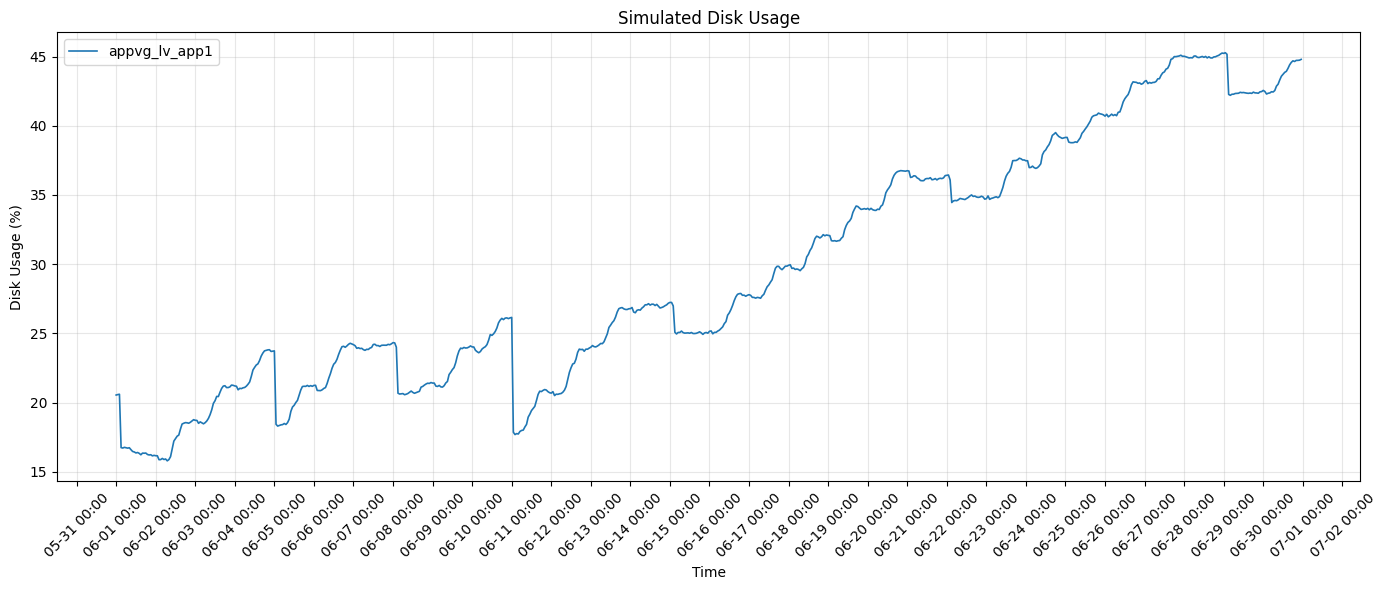

In [20]:
# 좀 더 복잡한 데이터
# 한달 동안의 단일 디스크 사용량 (현실적인 패턴)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta

np.random.seed(42)

# --- 파라미터 ---
days = 30
start_time = datetime(2025, 6, 1, 0, 0)
time_datetimes = pd.date_range(start=start_time, periods=days*24, freq="1H")

threshold = 98.0                 # 사실상 상한
start_usage = np.random.uniform(15, 30)

# 성장/감소 기본 레이트(시간당, %)
work_mu     = 0.20               # 평일 08~18시 증가 경향
off_mu      = 0.02               # 그 외 시간 미세 증가(로그/스냅샷 등)
weekend_mul = 0.4                # 주말은 증가율 축소
noise_sd    = 0.08               # 백색 잡음

# 일일/주간 정리 작업 (하락)
daily_cleanup_hour = 2           # 매일 02시 작은 정리
daily_cleanup_drop = (0.10, 0.35) # %
weekly_cleanup_wd  = 6           # 일요일(0=월 ... 6=일)
weekly_cleanup_hr  = 3           # 03시
weekly_cleanup_drop= (1.5, 4.0)  # %

# 가끔 큰 정리 이벤트(배치/보관정책)
big_purge_prob_per_day = 0.08
big_purge_drop = (3.0, 12.0)     # %

# 점심/오후 스파이크(쓰기 몰림)
spike_hours = [10, 11, 15, 16]
spike_boost = (0.05, 0.35)       # 추가 증가

usage = start_usage
vals  = []
events_drop_idx = []

for ts in time_datetimes:
    dow  = ts.dayofweek  # 0=Mon ... 6=Sun
    hr   = ts.hour
    is_work = (dow < 5) and (8 <= hr < 18)
    is_weekend = (dow >= 5)

    # 기본 증가율
    mu = work_mu if is_work else off_mu
    if is_weekend:
        mu *= weekend_mul

    # 스파이크 타임에 약간 추가
    if is_work and (hr in spike_hours):
        mu += np.random.uniform(*spike_boost)

    # 상한에 가까울수록 성장 둔화(포화 효과)
    saturation = max(0.15, 1.0 - (usage / 100.0) ** 2)
    delta = np.random.normal(mu, noise_sd) * saturation

    # 일일 정리(작은 하락)
    if hr == daily_cleanup_hour:
        drop = np.random.uniform(*daily_cleanup_drop)
        delta -= drop

    # 주간 정리(조금 큰 하락)
    if (dow == weekly_cleanup_wd) and (hr == weekly_cleanup_hr):
        drop = np.random.uniform(*weekly_cleanup_drop)
        delta -= drop

    # 큰 정리 이벤트: 하루에 한 번 확률 체크(해당 시 첫 시간에 적용)
    if hr == 1 and np.random.rand() < big_purge_prob_per_day:
        drop = np.random.uniform(*big_purge_drop)
        delta -= drop

    prev = usage
    usage = np.clip(prev + delta, 0.0, threshold)
    vals.append(usage)

    # 큰 하락 표시용(전 시간 대비 1%p 이상 하락 시 마커)
    if usage - prev <= -1.0:
        events_drop_idx.append(ts)

disk_usage = np.array(vals)

# DataFrame으로
df = pd.DataFrame({"disk_usage": disk_usage}, index=time_datetimes)
df.index.name = "timestamp"

# --- 시각화 ---
plt.figure(figsize=(14, 6))
ax = plt.gca()
ax.plot(df.index, df["disk_usage"], label='appvg_lv_app1', linewidth=1.2)

# # 큰 하락(정리 이벤트) 마킹
# if events_drop_idx:
#     ax.scatter(events_drop_idx, df.loc[events_drop_idx, "disk_usage"],
#                marker='v', s=35, color='tab:red', label='Cleanup/Purge')

ax.set_xlabel("Time")
ax.set_ylabel("Disk Usage (%)")
ax.set_title("Simulated Disk Usage")
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
plt.xticks(rotation=45)
# plt.axhline(threshold, color='red', linestyle='--', alpha=0.5, label=f'Threshold ({threshold:.0f}%)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ▼ (주의) 이미 df가 1시간 간격 30일이라면 time_index 재생성은 생략 or 길이 맞추기
# days = 30
# assert len(df) == days*24, "df 길이와 1H×30일이 불일치합니다."

past_steps   = 20
future_steps = 5

# 1) Train/Val/Test를 원본 df 기준으로 나누기
n_total = len(df)
n_train = int(n_total * 0.8)
n_val   = int(n_total * 0.1)

df_train = df.iloc[:n_train]
df_val   = df.iloc[n_train:n_train+n_val]
df_test  = df.iloc[n_train+n_val:]

# 2) 스케일러는 Train에만 fit
scaler = MinMaxScaler().fit(df_train[['disk_usage']])
disk_train = pd.DataFrame(scaler.transform(df_train[['disk_usage']]),
                          index=df_train.index, columns=['disk_usage'])
disk_val   = pd.DataFrame(scaler.transform(df_val[['disk_usage']]),
                          index=df_val.index,   columns=['disk_usage'])
disk_test  = pd.DataFrame(scaler.transform(df_test[['disk_usage']]),
                          index=df_test.index,  columns=['disk_usage'])

# 3) 시퀀스 생성
def create_sequences(df_1col, past_steps=20, future_steps=5):
    data = df_1col.values  # (N,1)
    X, y = [], []
    for i in range(len(data) - past_steps - future_steps):
        X.append(data[i:i+past_steps])                         # (past_steps,1)
        y.append(data[i+past_steps:i+past_steps+future_steps]) # (future_steps,1)
    X = np.array(X).astype('float32')
    y = np.array(y).squeeze(-1).astype('float32')              # -> (samples, future_steps)
    return X, y

X_train, y_train = create_sequences(disk_train, past_steps, future_steps)
X_val,   y_val   = create_sequences(disk_val,   past_steps, future_steps)
X_test,  y_test  = create_sequences(disk_test,  past_steps, future_steps)

# 4) 모델 (CNN + LSTM: LSTM은 기본 tanh 권장)
model = Sequential([
    Conv1D(64, kernel_size=3, padding='same', activation='relu', input_shape=(past_steps, 1)),
    MaxPooling1D(pool_size=2),
    Conv1D(64, kernel_size=3, padding='same', activation='relu'),
    LSTM(64),                 # activation='relu' 제거(=tanh)
    Dense(future_steps)
])
model.compile(optimizer='adam', loss='mse')

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=0)
]

history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=16,
    validation_data=(X_val, y_val),   # ← val_loss 로그 출력
    shuffle=False,                    # ← 시계열은 섞지 않기
    callbacks=callbacks,
    verbose=1
)

# 5) 예측 및 역스케일 (형상 주의)
pred = model.predict(X_test)                                   # (samples, future_steps)
true = y_test                                                  # (samples, future_steps)
pred_inv = scaler.inverse_transform(pred.reshape(-1,1)).reshape(-1, future_steps)
true_inv = scaler.inverse_transform(true.reshape(-1,1)).reshape(-1, future_steps)

# 6) 평가
print("MAE :", mean_absolute_error(true_inv.ravel(), pred_inv.ravel()))
print("RMSE:", np.sqrt(mean_squared_error(true_inv.ravel(), pred_inv.ravel())))
print("R²  :", r2_score(true_inv.ravel(), pred_inv.ravel()))

# (선택) horizon별 R²도 확인해보면 원인 파악에 좋아요
for j in range(future_steps):
    print(f"H{j+1} R2:", round(r2_score(true_inv[:, j], pred_inv[:, j]), 4))


Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0168 - val_loss: 0.0365 - learning_rate: 0.0010
Epoch 2/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0164 - val_loss: 0.0400 - learning_rate: 0.0010
Epoch 3/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0095 - val_loss: 0.0253 - learning_rate: 0.0010
Epoch 4/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0092 - val_loss: 0.0196 - learning_rate: 0.0010
Epoch 5/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0113 - val_loss: 0.0163 - learning_rate: 0.0010
Epoch 6/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0142 - val_loss: 0.0168 - learning_rate: 0.0010
Epoch 7/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0144 - val_loss: 0.0177 - learning_rate: 0.0010
Epoch 8/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0120 - val_loss: 0.0161 - learning_rate: 0.0010
Epoch 9/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0103 - val_loss: 0.0136 - learning_rate: 0.0010
Epoch 10/30
35/35 ━━━━━━━━━━━━━━━━━━━━

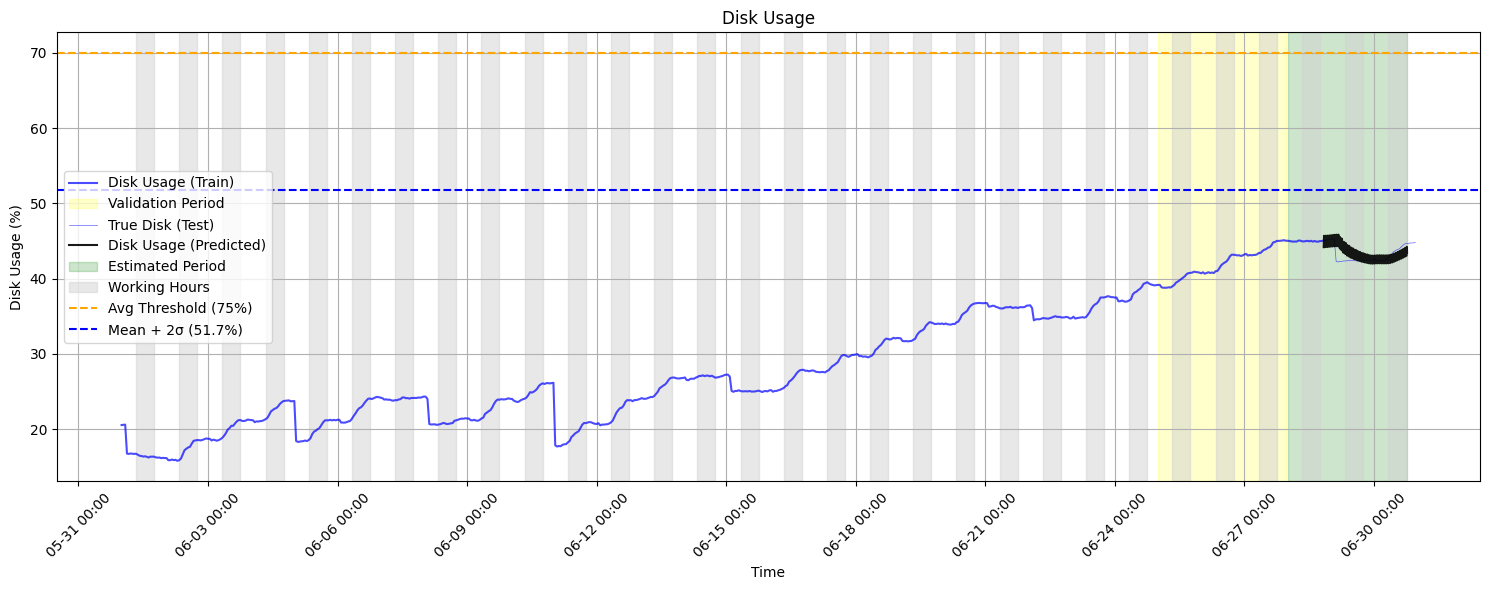

📊 Peak 발생 비율: 0.00%
✅ Peak 기준 만족 여부: False


In [24]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

# 1. 전체 예측 시계열 구성 (Train은 실제값, Test는 예측값)
all_pred_series = pd.concat([
    df['disk_usage'][:test_time_index[0]],       # Train 구간은 실제 측정값
    test_series_pred                      # Test 구간은 예측값
])
all_pred_series.name = "disk_usage"

# 2. 업무시간 (08:00~18:00), 비업무시간 추출
work_time = all_pred_series.between_time("08:00", "18:00")
nowork_time = all_pred_series.between_time("18:00", "07:00")

# 3. 조건 1: 평균 Memory 사용률 ≥ 70% (업무시간, 비업무시간 분리)
avg_threshold = 70
work_time_flag = work_time.mean() >= avg_threshold
nowork_time_flag = nowork_time.mean() >= avg_threshold
condition1_flag = work_time_flag or nowork_time_flag # 업무시간 또는 비업무 시간에 average 80 % 이상이면 증설 필요

# 조건2 수정 : μ + 2σ 이상
mu = all_pred_series.mean()
sigma = all_pred_series.std()
rel_threshold = mu + 2 * sigma           # 평균 + 2σ
daily_peak_flags = all_pred_series > rel_threshold

daily_peak = daily_peak_flags.groupby(daily_peak_flags.index.date).any()
peak_days = daily_peak.sum()
total_days = len(daily_peak)
condition2_flag = (peak_days / total_days) >= 0.05   # A등급 피크 비율 5%

# 5. 증설 판단
upgrade_flag = condition1_flag or condition2_flag

# 6. Upgrade 표시할 시간대 지정
if condition1_flag:
    upgrade_times = work_time.index

elif condition2_flag:
    # 조건 2 충족 시 peak 발생일 기준
    peak_day_list = daily_peak[daily_peak].index[:5]  # 최대 5일
    # upgrade_times = work_time[work_time.index.date.astype(str).isin(peak_day_list.astype(str))].index
    upgrade_times = work_time[pd.Index(work_time.index.date).isin(peak_day_list)].index
else:
    upgrade_times = []

# 7. 시각화 (Train과 Test 색상 구분)
fig, ax = plt.subplots(figsize=(15, 6))

# Train 구간
train_series = df['disk_usage'][:test_time_index[0]]
ax.plot(train_series.index, train_series.values, label="Disk Usage (Train)", color="blue", alpha=0.7)

# Validation 구간에 색상 입히기
val_start = val_series.index[0]
val_end = val_series.index[-1]
ax.axvspan(val_start, val_end, color='yellow', alpha=0.2, label="Validation Period")

# Test 구간
plt.plot(test_series_true, label="True Disk (Test)", color="blue", alpha = 0.6, linewidth = 0.5) # test 정답값
ax.plot(test_series_pred.index, test_series_pred.values, label="Disk Usage (Predicted)", color="black",alpha=0.9)
# test_start = test_series_pred.index[0]
# test_end = test_series_pred.index[-1]
test_context_start = mem_test.index[0]   # 컨텍스트 시작
test_pred_start    = test_series_pred.index[0]
test_end           = test_series_pred.index[-1]

ax.axvspan(test_context_start, test_end, color='green', alpha=0.2, label="Estimated Period")
# ax.axvspan(test_start, test_end, color='green', alpha=0.2, label="Estimated Period")

# 업무시간 배경 색칠
unique_dates = pd.to_datetime(all_pred_series.index.date).unique()
first = True
for date in unique_dates:
    start = pd.Timestamp(f"{date} 08:00")
    end = pd.Timestamp(f"{date} 18:00")
    label = "Working Hours" if first else None  # 첫 번째에만 라벨 부여
    ax.axvspan(start, end, color='lightgray', alpha=0.5, label=label)
    first = False

# 기준선
ax.axhline(avg_threshold, color='orange', linestyle='--', label="Avg Threshold (75%)")
plt.axhline(rel_threshold, color="blue", linestyle="--", label=f"Mean + 2σ ({rel_threshold:.1f}%)")
# plt.axhline(abs_threshold, color="green", linestyle="--", label=f"90th Percentile ({abs_threshold:.1f}%)")
# plt.axhline(peak_threshold, color="red", linestyle="-.", label=f"Mixed Threshold ({peak_threshold:.1f}%)")

# 마무리 설정
ax.set_title("Disk Usage")
ax.set_xlabel("Time")
ax.set_ylabel("Disk Usage (%)")
ax.legend()
ax.grid(True)
ax.xaxis.set_major_locator(mdates.DayLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
plt.setp(ax.get_xticklabels(), rotation=45, ha="center")
plt.tight_layout()
plt.show()

# ✅ Peak 기준 값 계산
peak_ratio = (peak_days / total_days) * 100  # 퍼센트(%)

# ✅ 조건 2 결과 출력

print(f"📊 Peak 발생 비율: {peak_ratio:.2f}%")
print(f"✅ Peak 기준 만족 여부: {condition2_flag}")

# streamlit 위한 csv 저장

# 평균 사용률 저장
Disk_avg_df = pd.DataFrame({
    'type': ['work', 'nowork'],
    'avg_usage': [work_time.mean(), nowork_time.mean()]
})
Disk_avg_df.to_csv("Disk_avg_usage_CNN-LSTM.csv", index=False)

import json
with open("Disk_accuracy_metrics_CNN-LSTM.json", "w") as f:
    json.dump(metrics, f)

all_pred_series.to_csv("Disk_all_series_CNN-LSTM.csv") # 전체 Memory
test_series_pred.to_csv("Disk_usage_predicted_only_CNN-LSTM.csv") # 예측 구간 Memory
work_time.to_csv("Disk_usage_working_hours_CNN-LSTM.csv") # 업무시간 Memory
daily_peak.to_csv("Disk_peak_flag_per_day_CNN-LSTM.csv") # peak 발생 여부

with open("Disk_upgrade_decision_CNN-LSTM.txt", "w") as f: # 업그레이드 유무
    f.write(f"Condition 1: {condition1_flag} ({work_time.mean():.2f}%)\n")
    f.write(f"Condition 2: {condition2_flag} ({peak_days}/{total_days})\n")
    f.write(f"Final Decision: {'Upgrade Needed' if upgrade_flag else 'No Upgrade Required'}\n")
fig.savefig("Disk_plot_CNN-LSTM.png")

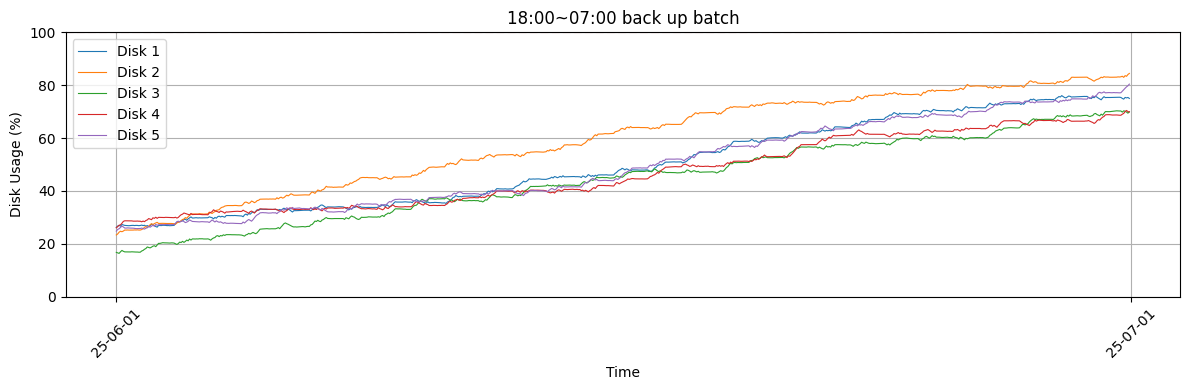

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta

# 시뮬레이션 설정
months = 1
days_per_month = 30
hours_per_day = 24
steps_per_month = days_per_month * hours_per_day  # 720시간
total_steps = months * steps_per_month  # 8640시간

n_disks = 5
disk_usage_year = np.zeros((n_disks, total_steps))
time_datetimes_year = []

start_time = datetime(2025, 6, 1, 0, 0)
backup_hours = list(range(18, 24)) + list(range(0, 7))

for d in range(n_disks):
    usage = np.random.uniform(10, 20)  # 초기 사용량 (0~90 기준)
    for m in range(months):
        month_scale = (m + 1) / months  # 점점 증가 (1/12 ~ 12/12)
        for t in range(steps_per_month):
            current_hour = t % 24
            if current_hour in backup_hours:
                if np.random.rand() < 0.6:
                    usage += np.random.uniform(0.08, 0.5) * month_scale
                else:
                    usage -= np.random.uniform(0.1, 0.3)
            else:
                usage += np.random.normal(0, 0.03) * month_scale
            usage = np.clip(usage, 0, 80)  # 최대제한
            global_idx = m * steps_per_month + t
            disk_usage_year[d, global_idx] = usage
            if d == 0:
                time_datetimes_year.append(start_time + timedelta(hours=global_idx))

# % 변환
disk_usage = (disk_usage_year / 70) * 100

# 시각화
plt.figure(figsize=(12, 4))
for d in range(n_disks):
    plt.plot(time_datetimes_year, disk_usage[d], label=f'Disk {d+1}', linewidth=0.8)

plt.xlabel("Time")
plt.ylabel("Disk Usage (%)")
plt.title("18:00~07:00 back up batch")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.xticks(rotation=45)
plt.axhline(100, color='red', linestyle='--', alpha=0.5)
plt.ylim(0, 100)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# disk data 생성
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense


# 시뮬레이션 (5개 디스크 개별)
months = 1
days_per_month = 30
hours_per_day = 24
steps_per_month = days_per_month * hours_per_day
total_steps = months * steps_per_month

n_disks = 5
disk_usage_year = np.zeros((n_disks, total_steps))
time_datetimes_year = []

start_time = pd.Timestamp('2025-06-01 00:00:00')
backup_hours = list(range(18, 24)) + list(range(0, 7))

for d in range(n_disks):
    usage = np.random.uniform(10, 20)
    for m in range(months):
        month_scale = (m + 1) / months
        for t in range(steps_per_month):
            current_hour = t % 24
            if current_hour in backup_hours:
                if np.random.rand() < 0.6:
                    usage += np.random.uniform(0.08, 0.5) * month_scale
                else:
                    usage -= np.random.uniform(0.1, 0.3)
            else:
                usage += np.random.normal(0, 0.03) * month_scale
            usage = np.clip(usage, 0, 80)
            global_idx = m * steps_per_month + t
            disk_usage_year[d, global_idx] = usage
            if d == 0:
                time_datetimes_year.append(start_time + pd.Timedelta(hours=global_idx))

disk_usage_percent = (disk_usage_year / 90) * 100
time_index = pd.DatetimeIndex(time_datetimes_year)
df_disks = pd.DataFrame(disk_usage_percent.T, columns=[f'Disk{i+1}' for i in range(n_disks)], index=time_index)

# df_disks_resample = df_disks # resample 없는 경우
# resampling
df_disks_resample = df_disks.resample('30T').interpolate('linear')

# 시퀀스 생성 함수
def create_sequences(data, past_steps=20, future_steps=5):
    X, y = [], []
    for i in range(len(data) - past_steps - future_steps):
        X.append(data[i:i+past_steps])
        y.append(data[i+past_steps:i+past_steps+future_steps])
    return np.array(X), np.array(y)


/tmp/ipython-input-1707394311.py:50: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_disks_resample = df_disks.resample('30T').interpolate('linear')


## 1. CNN-LSTM 적용 + sliding window(5)
### 각각의 디스크가 영향없이 독립적으로 -> 각각 학습 시켜야해


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step

=== Disk 1 - CNN-LSTM 결과 ===
MAE : 0.5482026175528288
RMSE: 0.6990919441862528
R²  : 0.8896307710718128


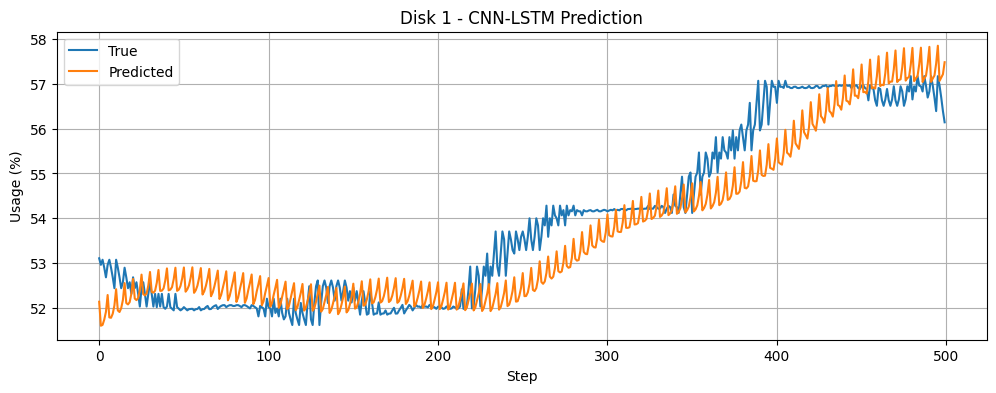

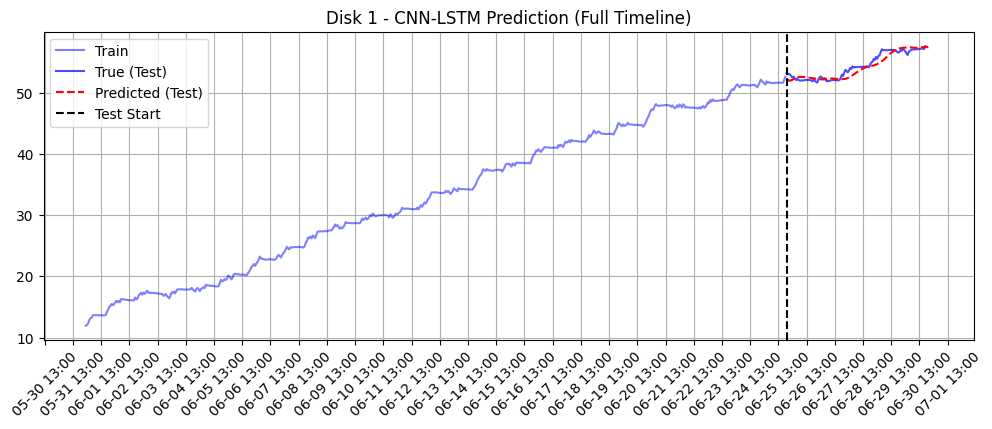

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step

=== Disk 2 - CNN-LSTM 결과 ===
MAE : 0.4525740841396188
RMSE: 0.5595034423940264
R²  : 0.8338047879036234


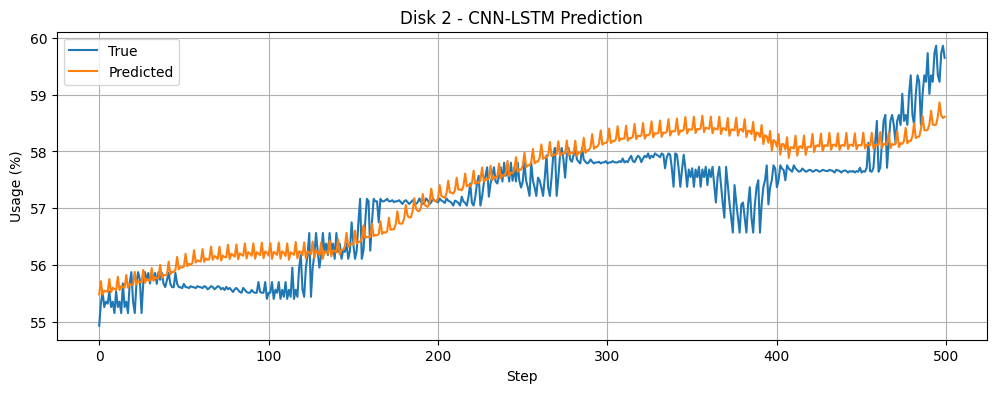

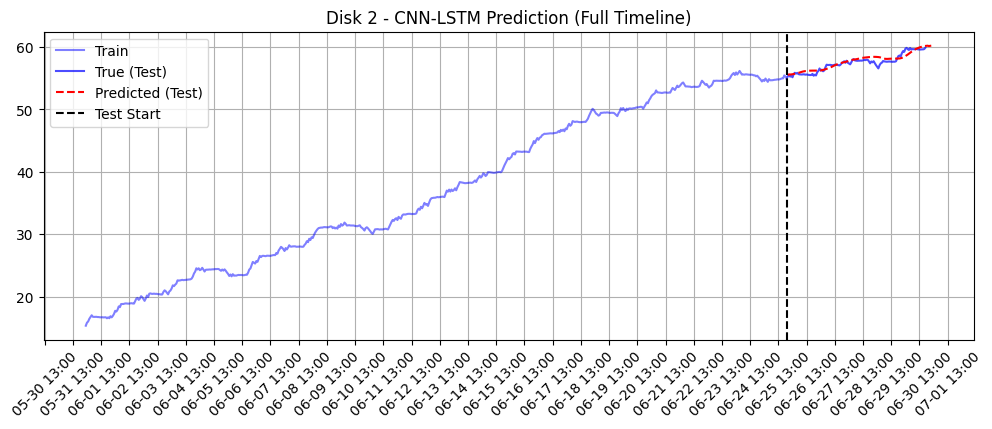

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step

=== Disk 3 - CNN-LSTM 결과 ===
MAE : 0.6296073312771828
RMSE: 0.7995815882768804
R²  : 0.4265802963927253


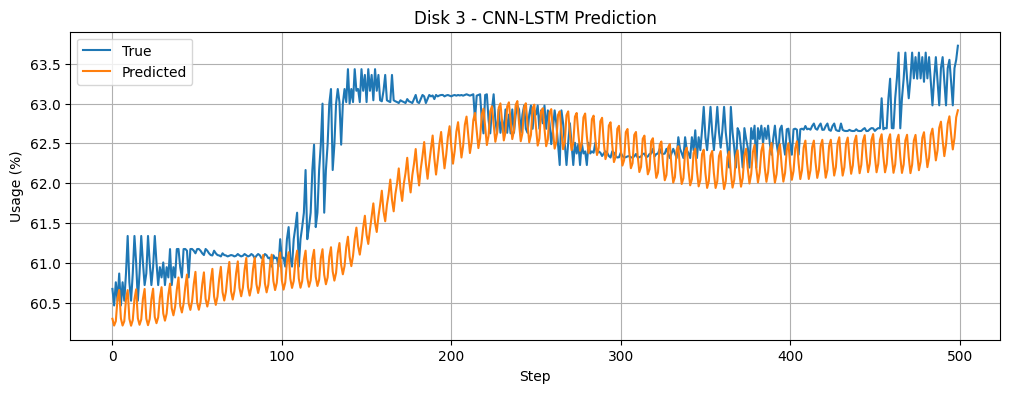

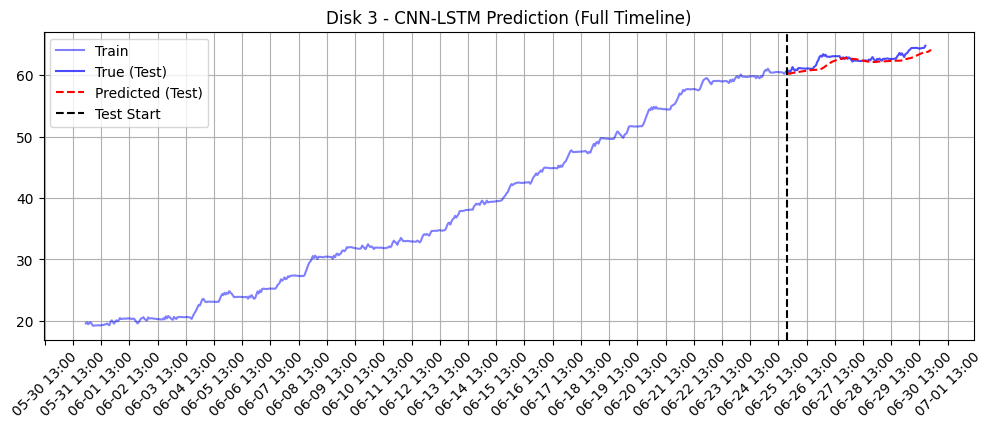

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step

=== Disk 4 - CNN-LSTM 결과 ===
MAE : 1.1033433561782795
RMSE: 1.2039477884614953
R²  : 0.7235087457758687


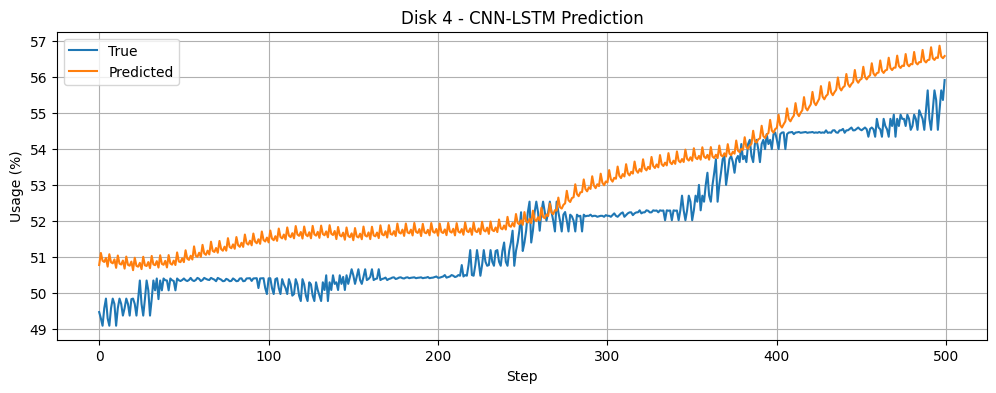

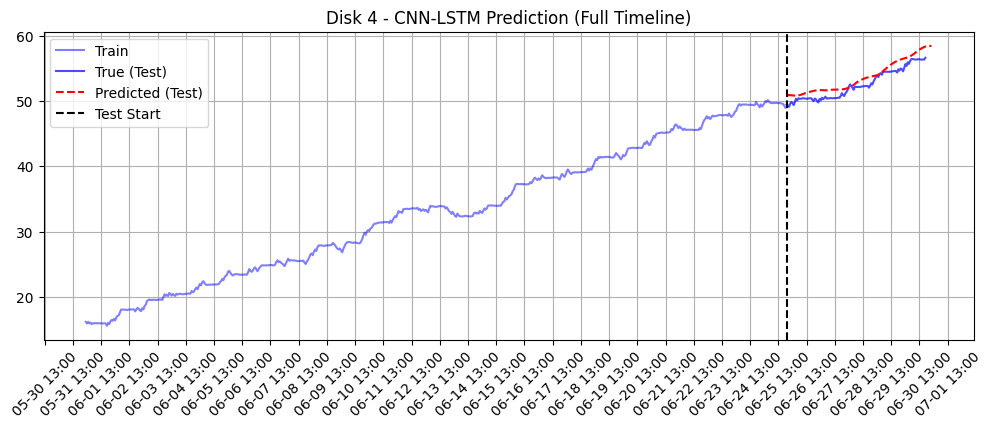

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step

=== Disk 5 - CNN-LSTM 결과 ===
MAE : 0.9846004338641281
RMSE: 1.1525140274280163
R²  : 0.6639826713685408


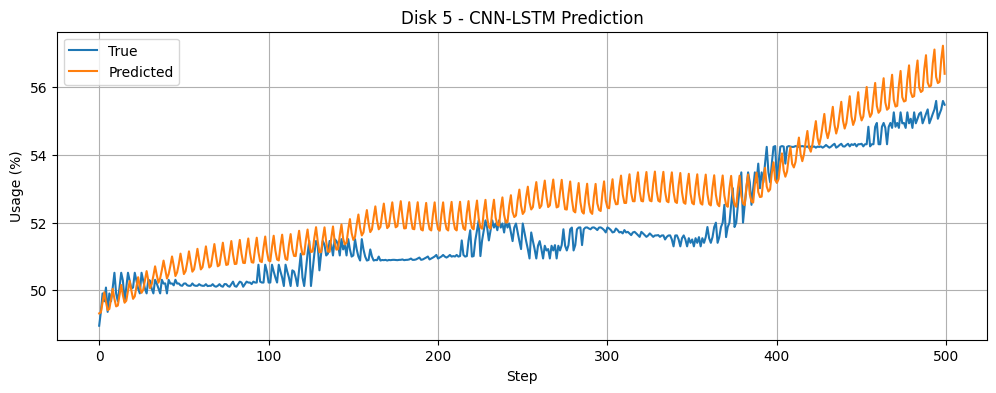

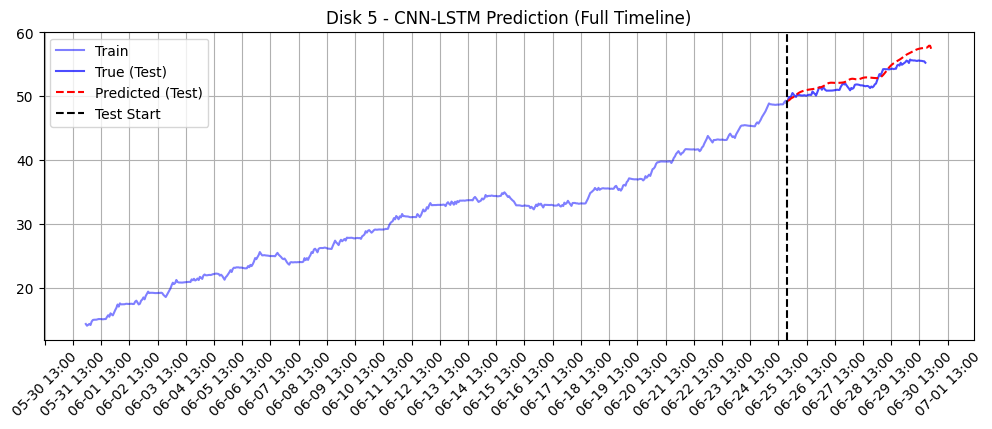

In [ ]:
# ---------- 시계열 설정 ----------
past_steps = 20
future_steps = 5
split_ratio = 0.8

def create_sequences(data, past_steps, future_steps):
    X, y = [], []
    for i in range(len(data) - past_steps - future_steps):
        X.append(data[i:i+past_steps])
        y.append(data[i+past_steps:i+past_steps+future_steps])
    return np.array(X), np.array(y)

# ---------- 디스크별 예측 ----------
for d in range(n_disks):
    usage = df_disks.iloc[:, d].values.reshape(-1, 1)
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(usage)
    df_scaled = pd.DataFrame(scaled)

    train_size = int(len(df_scaled) * split_ratio)
    df_train = df_scaled.iloc[:train_size]
    df_test = df_scaled.iloc[train_size:]

    X_train, y_train = create_sequences(df_train[0].values, past_steps, future_steps)
    X_test, y_test = create_sequences(df_test[0].values, past_steps, future_steps)

    X_train_cnn = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test_cnn = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

    model = Sequential([
        Conv1D(64, kernel_size=3, activation='relu', input_shape=(past_steps, 1)),
        MaxPooling1D(pool_size=2),
        LSTM(64, activation='relu'),
        Dense(future_steps)
    ])
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train_cnn, y_train, epochs=50, batch_size=16, verbose=0)

    # ---------- 예측 ----------
    pred = model.predict(X_test_cnn)
    pred_inv = scaler.inverse_transform(pred)
    true_inv = scaler.inverse_transform(y_test)

    print(f"\n=== Disk {d+1} - CNN-LSTM 결과 ===")
    print("MAE :", mean_absolute_error(true_inv.flatten(), pred_inv.flatten()))
    print("RMSE:", np.sqrt(mean_squared_error(true_inv.flatten(), pred_inv.flatten())))
    print("R²  :", r2_score(true_inv.flatten(), pred_inv.flatten()))

    # ---------- 예측값만 시각화 ----------
    plt.figure(figsize=(12, 4))
    plt.plot(true_inv.flatten()[:500], label="True")
    plt.plot(pred_inv.flatten()[:500], label="Predicted")
    plt.title(f"Disk {d+1} - CNN-LSTM Prediction")
    plt.ylabel("Usage (%)")
    plt.xlabel("Step")
    plt.legend()
    plt.grid(True)
    plt.show()

    # ---------- 전체 시계열 예측 시각화 ----------
    df_disk = df_disks.iloc[:, d]
    test_start_idx = int(len(df_disk) * split_ratio)
    test_time_index = df_disk.index[test_start_idx + past_steps : test_start_idx + past_steps + len(pred)]

    # 원래 시계열 (train + test)
    train_series = df_disk[:test_start_idx + past_steps]
    test_series_true = pd.Series(true_inv[:, 0], index=test_time_index)

    # 5-스텝 예측 시간 생성
    all_future_times, all_future_preds = [], []
    for i in range(len(test_time_index)):
        for j in range(future_steps):
            future_time = test_time_index[i] + pd.Timedelta(hours=(j + 1))
            all_future_times.append(future_time)
            all_future_preds.append(pred[i, j])

    pred_df = pd.DataFrame({"time": all_future_times,
                            "pred": scaler.inverse_transform(np.array(all_future_preds).reshape(-1, 1)).flatten()})
    pred_df_mean = pred_df.groupby("time").mean().sort_index()
    test_series_pred = pd.Series(pred_df_mean['pred'], index=pred_df_mean.index)

    fig, ax = plt.subplots(figsize=(12, 4))
    ax.plot(train_series, label="Train", color="blue", alpha=0.5)
    ax.plot(test_series_true, label="True (Test)", color="blue", alpha=0.7)
    ax.plot(test_series_pred, label="Predicted (Test)", color="red", linestyle="--")
    ax.axvline(test_time_index[0], color="black", linestyle="--", label="Test Start")
    ax.xaxis.set_major_locator(mdates.HourLocator(interval=24))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
    plt.setp(ax.get_xticklabels(), rotation=45)
    plt.title(f"Disk {d+1} - CNN-LSTM Prediction (Full Timeline)")
    plt.legend()
    plt.grid(True)
    plt.show()

## CNN

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step

=== Disk 1 - CNN-only 결과 ===
MAE : 0.5352353003869701
RMSE: 0.6753969112982532
R²  : 0.8969856910477408


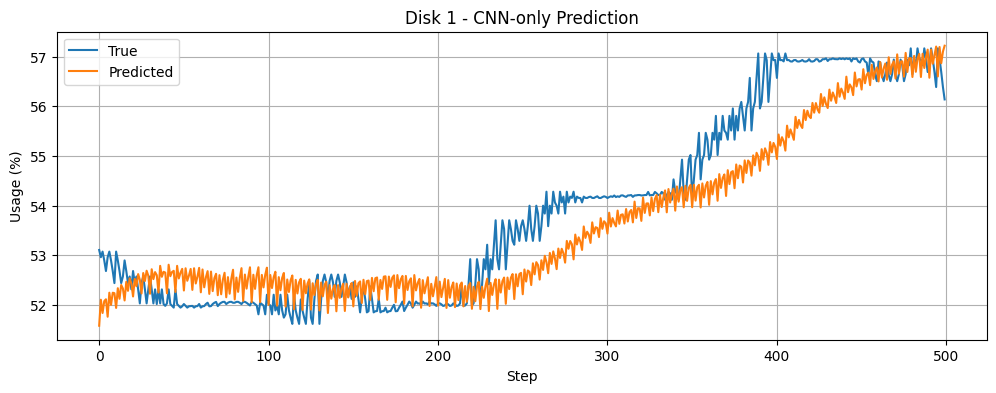

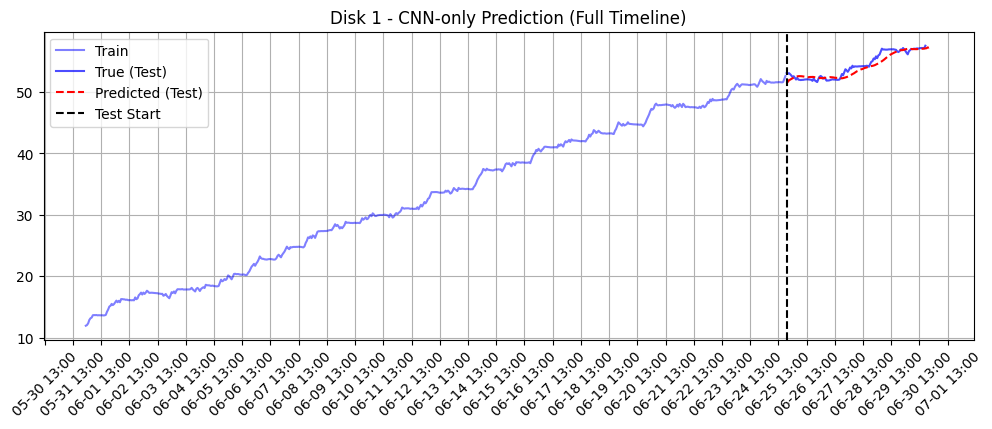

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step

=== Disk 2 - CNN-only 결과 ===
MAE : 0.4528129571148828
RMSE: 0.6137064484329859
R²  : 0.8000440390962943


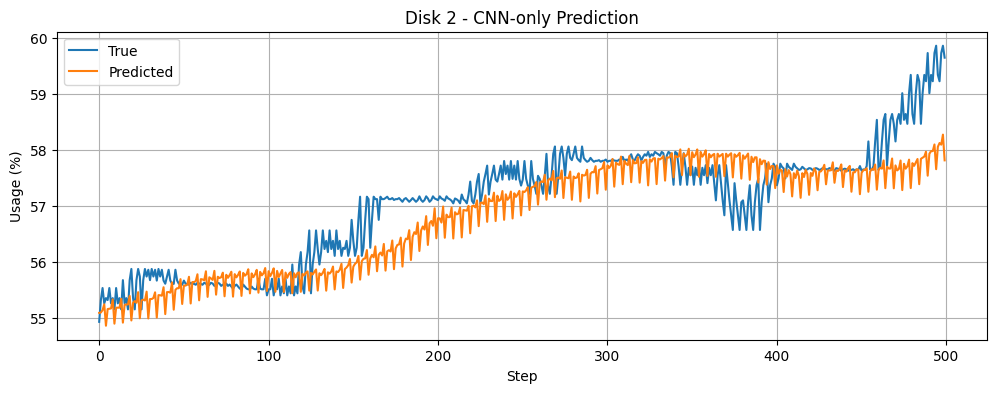

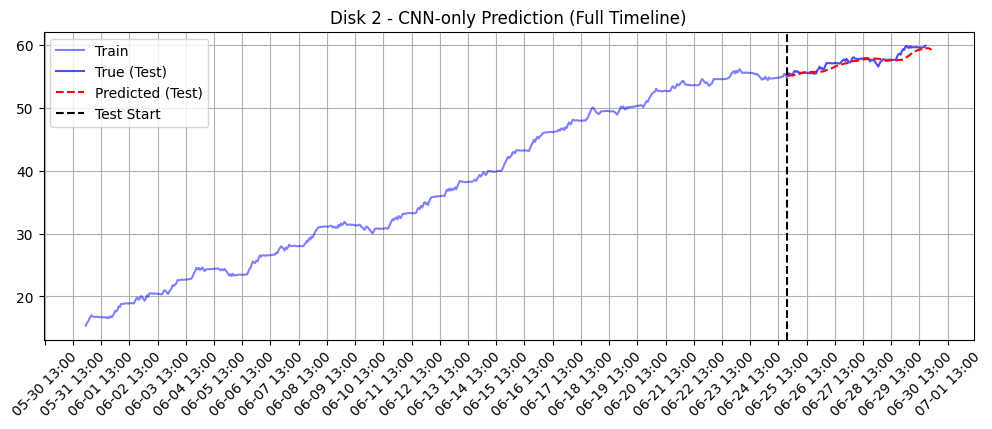

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step

=== Disk 3 - CNN-only 결과 ===
MAE : 0.46219215824692367
RMSE: 0.6146163880085553
R²  : 0.6611907072126382


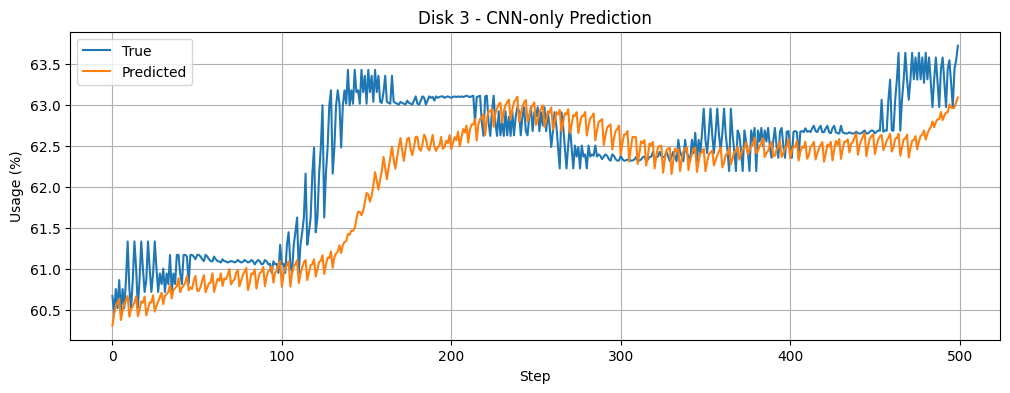

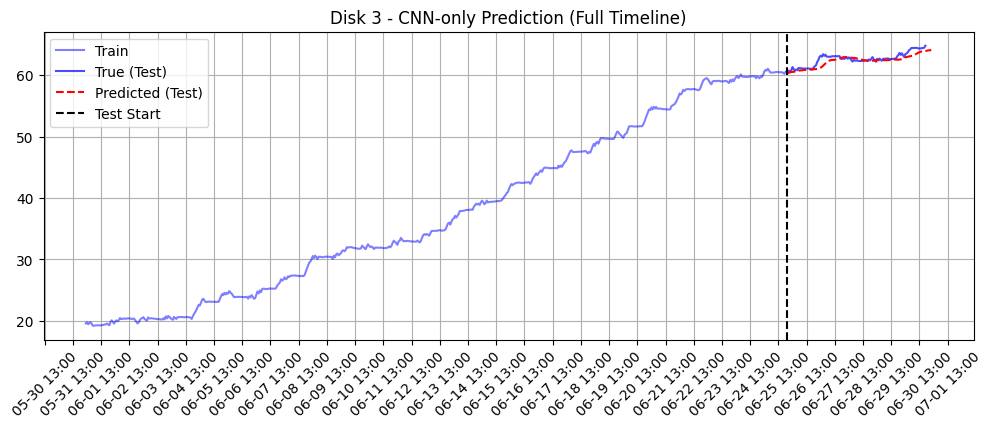

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step

=== Disk 4 - CNN-only 결과 ===
MAE : 0.4992267205208512
RMSE: 0.5789053769242238
R²  : 0.936073451225609


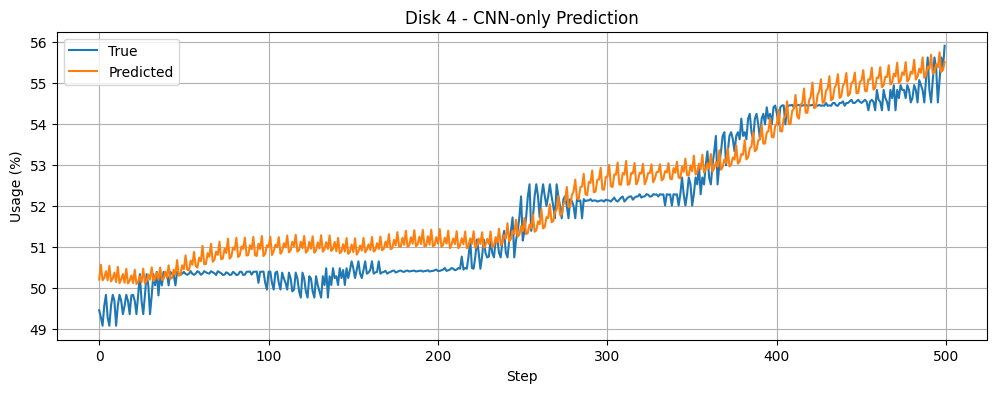

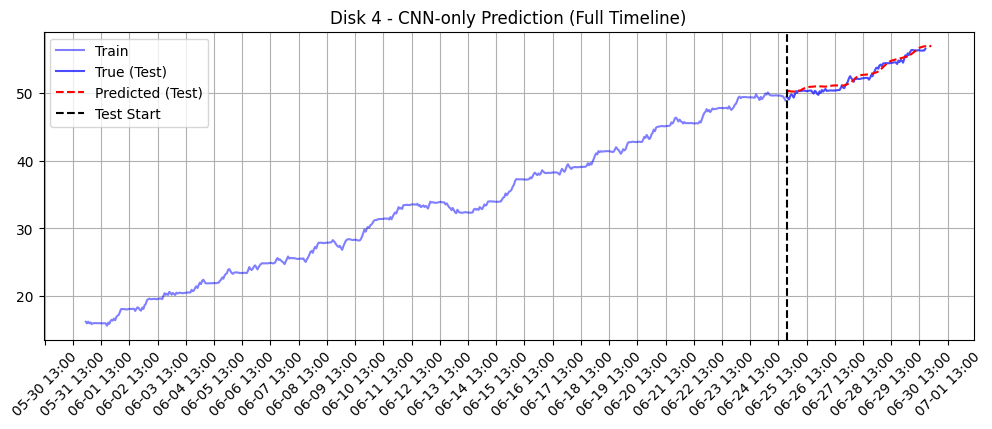

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step

=== Disk 5 - CNN-only 결과 ===
MAE : 0.8979941285697159
RMSE: 0.9942328490901184
R²  : 0.7499392952412032


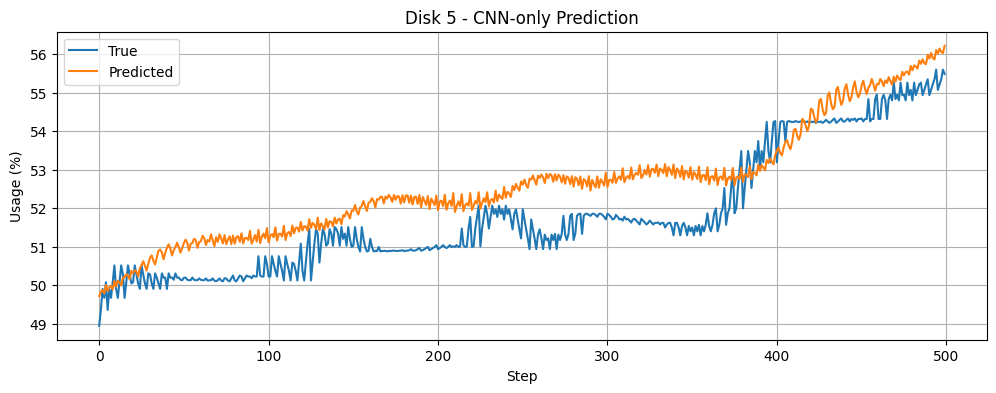

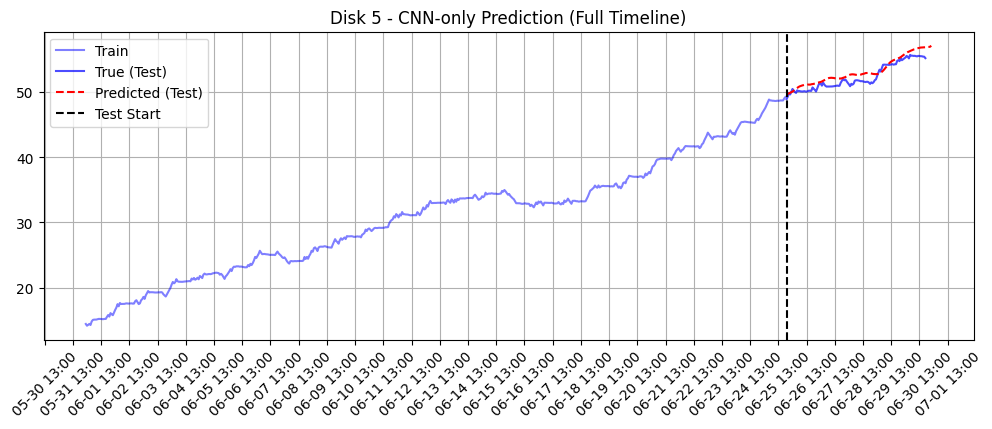

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

past_steps = 20
future_steps = 5
split_ratio = 0.8

def create_sequences(data, past_steps, future_steps):
    X, y = [], []
    for i in range(len(data) - past_steps - future_steps):
        X.append(data[i:i+past_steps])
        y.append(data[i+past_steps:i+past_steps+future_steps])
    return np.array(X), np.array(y)

# ---------- 디스크별 예측 ----------
for d in range(n_disks):
    usage = df_disks.iloc[:, d].values.reshape(-1, 1)
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(usage)
    df_scaled = pd.DataFrame(scaled)

    train_size = int(len(df_scaled) * split_ratio)
    df_train = df_scaled.iloc[:train_size]
    df_test = df_scaled.iloc[train_size:]

    X_train, y_train = create_sequences(df_train[0].values, past_steps, future_steps)
    X_test, y_test = create_sequences(df_test[0].values, past_steps, future_steps)

    X_train_cnn = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test_cnn = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

    # ---------- CNN-only 모델 ----------
    model = Sequential([
        Conv1D(64, kernel_size=3, activation='relu', input_shape=(past_steps, 1)),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(future_steps)
    ])
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train_cnn, y_train, epochs=50, batch_size=16, verbose=0)

    # ---------- 예측 ----------
    pred = model.predict(X_test_cnn)
    pred_inv = scaler.inverse_transform(pred)
    true_inv = scaler.inverse_transform(y_test)

    print(f"\n=== Disk {d+1} - CNN-only 결과 ===")
    print("MAE :", mean_absolute_error(true_inv.flatten(), pred_inv.flatten()))
    print("RMSE:", np.sqrt(mean_squared_error(true_inv.flatten(), pred_inv.flatten())))
    print("R²  :", r2_score(true_inv.flatten(), pred_inv.flatten()))

    # ---------- 예측값만 시각화 ----------
    plt.figure(figsize=(12, 4))
    plt.plot(true_inv.flatten()[:500], label="True")
    plt.plot(pred_inv.flatten()[:500], label="Predicted")
    plt.title(f"Disk {d+1} - CNN-only Prediction")
    plt.ylabel("Usage (%)")
    plt.xlabel("Step")
    plt.legend()
    plt.grid(True)
    plt.show()

    # ---------- 전체 시계열 예측 시각화 ----------
    df_disk = df_disks.iloc[:, d]
    test_start_idx = int(len(df_disk) * split_ratio)
    test_time_index = df_disk.index[test_start_idx + past_steps : test_start_idx + past_steps + len(pred)]

    train_series = df_disk[:test_start_idx + past_steps]
    test_series_true = pd.Series(true_inv[:, 0], index=test_time_index)

    # 5-스텝 예측 시간 생성
    all_future_times, all_future_preds = [], []
    for i in range(len(test_time_index)):
        for j in range(future_steps):
            future_time = test_time_index[i] + pd.Timedelta(hours=(j + 1))
            all_future_times.append(future_time)
            all_future_preds.append(pred[i, j])

    pred_df = pd.DataFrame({"time": all_future_times,
                            "pred": scaler.inverse_transform(np.array(all_future_preds).reshape(-1, 1)).flatten()})
    pred_df_mean = pred_df.groupby("time").mean().sort_index()
    test_series_pred = pd.Series(pred_df_mean['pred'], index=pred_df_mean.index)

    fig, ax = plt.subplots(figsize=(12, 4))
    ax.plot(train_series, label="Train", color="blue", alpha=0.5)
    ax.plot(test_series_true, label="True (Test)", color="blue", alpha=0.7)
    ax.plot(test_series_pred, label="Predicted (Test)", color="red", linestyle="--")
    ax.axvline(test_time_index[0], color="black", linestyle="--", label="Test Start")
    ax.xaxis.set_major_locator(mdates.HourLocator(interval=24))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
    plt.setp(ax.get_xticklabels(), rotation=45)
    plt.title(f"Disk {d+1} - CNN-only Prediction (Full Timeline)")
    plt.legend()
    plt.grid(True)
    plt.show()

## CNN-BiLSTM

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step

=== Disk 1 - CNN-BiLSTM 결과 ===
MAE : 0.9117638432008036
RMSE: 1.0569590835579135
R²  : 0.747712482107046


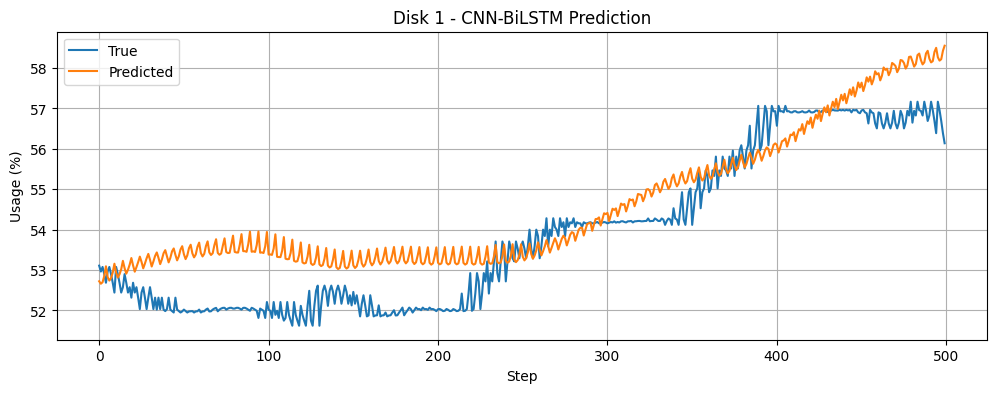

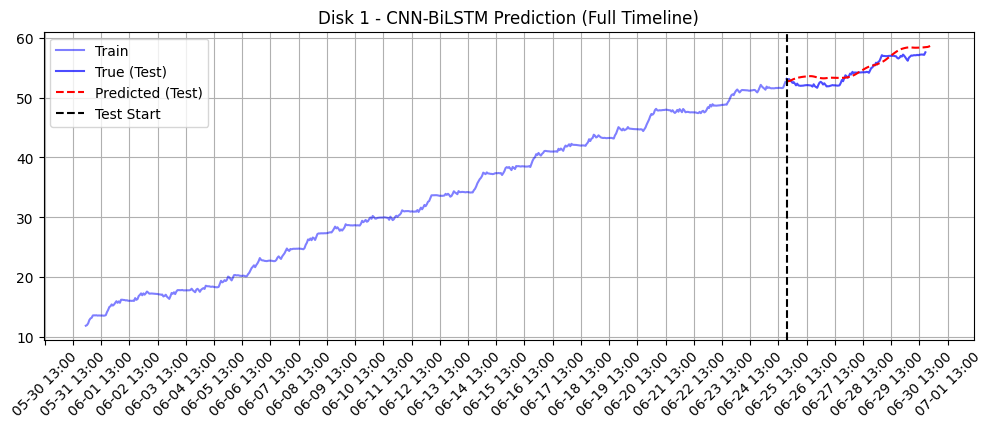

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step

=== Disk 2 - CNN-BiLSTM 결과 ===
MAE : 0.3744612679196001
RMSE: 0.4911818374872056
R²  : 0.8719152039270004


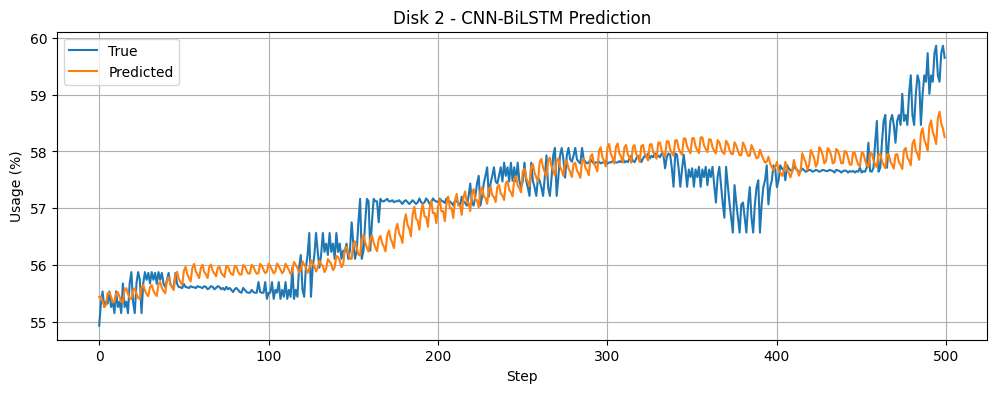

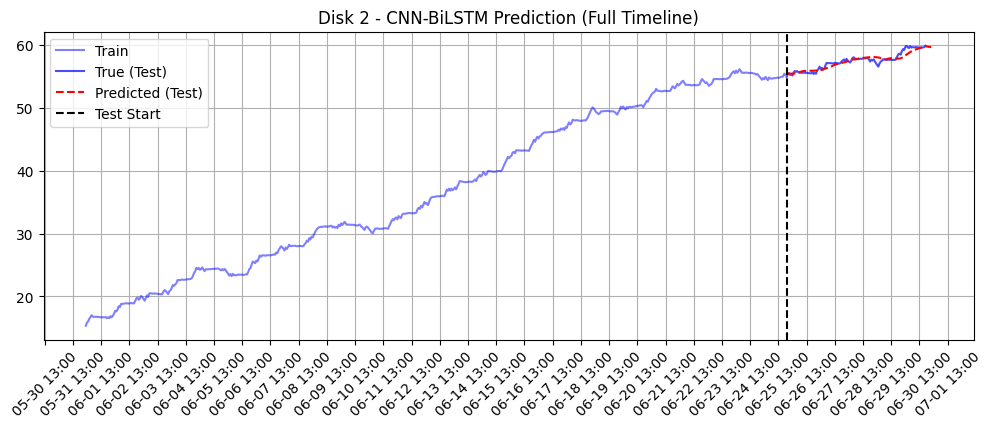

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 155ms/step

=== Disk 3 - CNN-BiLSTM 결과 ===
MAE : 0.5294538398014625
RMSE: 0.6192310108945347
R²  : 0.6560839559257584


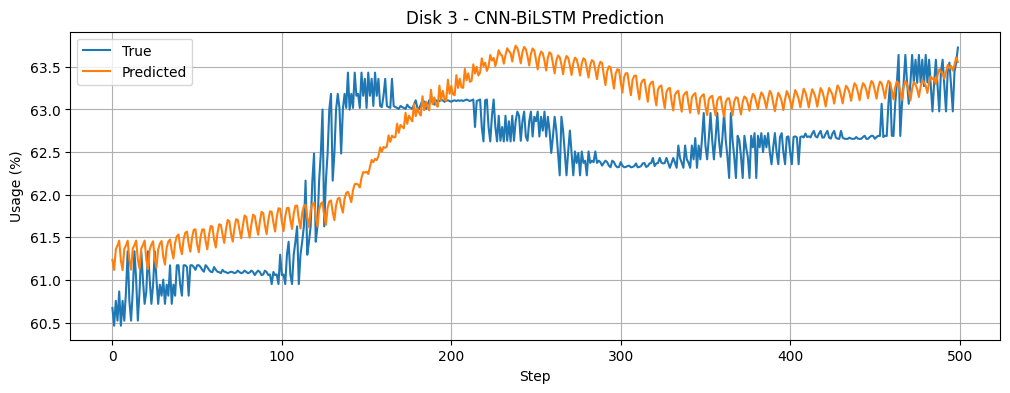

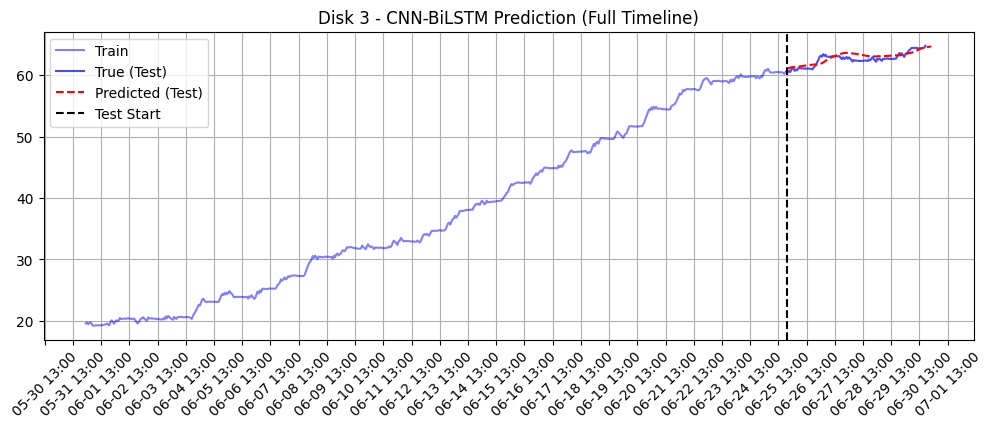

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step

=== Disk 4 - CNN-BiLSTM 결과 ===
MAE : 0.5754011402610072
RMSE: 0.6590240892664133
R²  : 0.9171545481092631


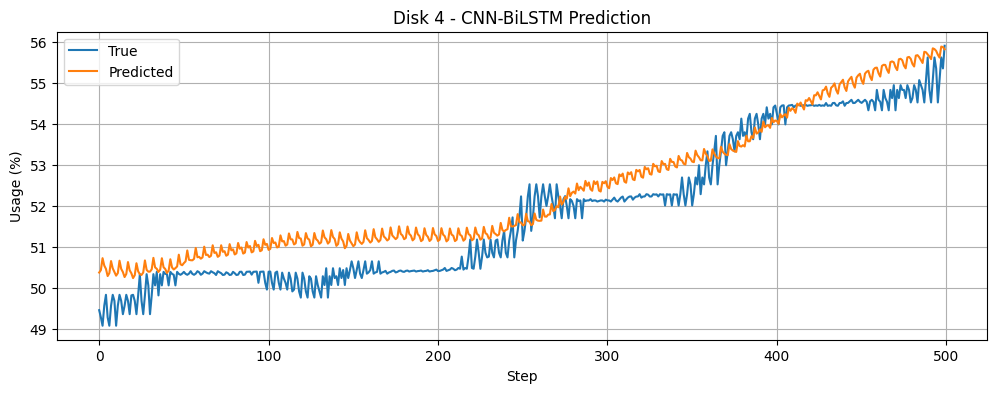

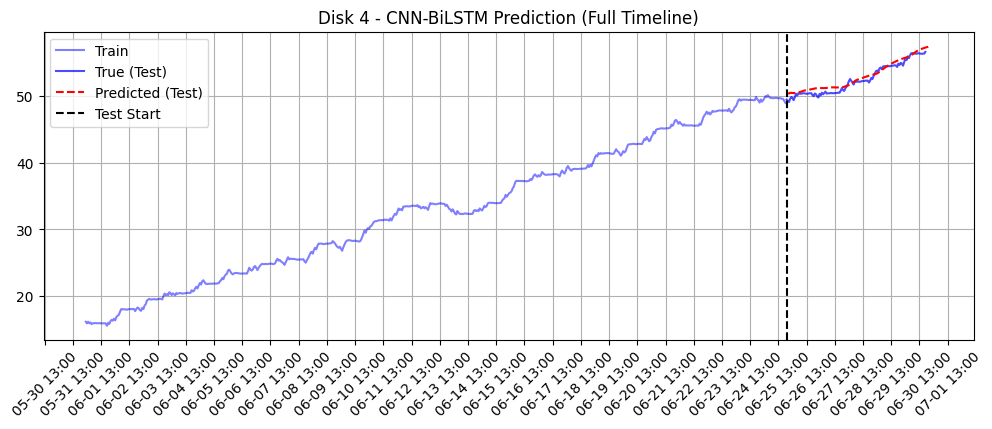

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step

=== Disk 5 - CNN-BiLSTM 결과 ===
MAE : 0.9989698999295668
RMSE: 1.1366529007327233
R²  : 0.6731677046030966


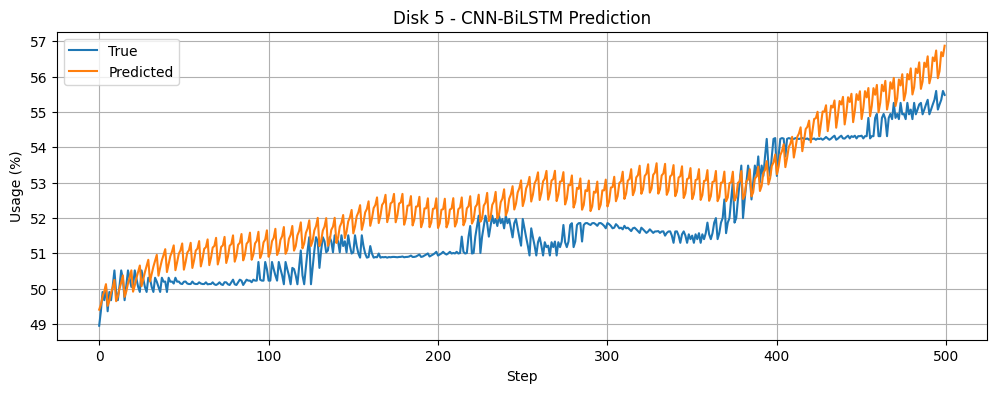

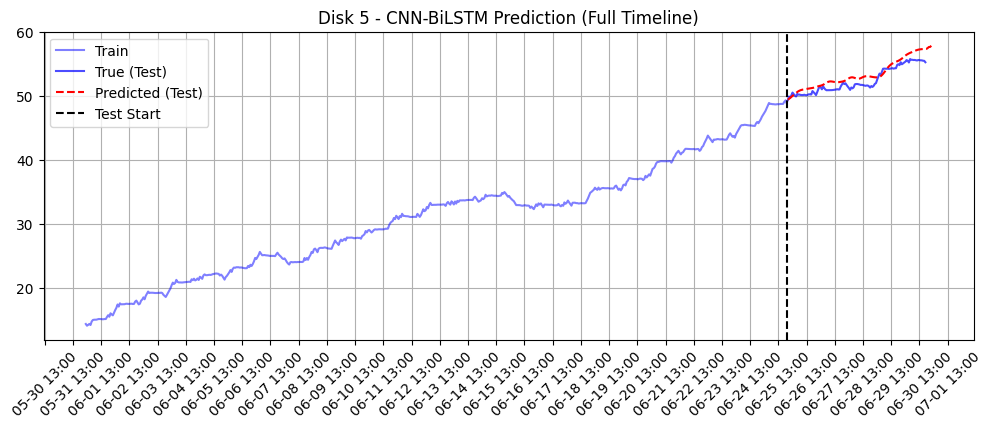

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense

# ---------- 디스크별 예측 ----------
for d in range(n_disks):
    usage = df_disks.iloc[:, d].values.reshape(-1, 1)
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(usage)
    df_scaled = pd.DataFrame(scaled)

    train_size = int(len(df_scaled) * split_ratio)
    df_train = df_scaled.iloc[:train_size]
    df_test = df_scaled.iloc[train_size:]

    X_train, y_train = create_sequences(df_train[0].values, past_steps, future_steps)
    X_test, y_test = create_sequences(df_test[0].values, past_steps, future_steps)

    X_train_cnn = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test_cnn = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

    # ---------- CNN-BiLSTM 모델 ----------
    model = Sequential([
        Conv1D(64, kernel_size=3, activation='relu', input_shape=(past_steps, 1)),
        MaxPooling1D(pool_size=2),
        Bidirectional(LSTM(64, activation='relu')),
        Dense(future_steps)
    ])
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train_cnn, y_train, epochs=50, batch_size=16, verbose=0)

    # ---------- 예측 ----------
    pred = model.predict(X_test_cnn)
    pred_inv = scaler.inverse_transform(pred)
    true_inv = scaler.inverse_transform(y_test)

    print(f"\n=== Disk {d+1} - CNN-BiLSTM 결과 ===")
    print("MAE :", mean_absolute_error(true_inv.flatten(), pred_inv.flatten()))
    print("RMSE:", np.sqrt(mean_squared_error(true_inv.flatten(), pred_inv.flatten())))
    print("R²  :", r2_score(true_inv.flatten(), pred_inv.flatten()))

    # ---------- 예측값만 시각화 ----------
    plt.figure(figsize=(12, 4))
    plt.plot(true_inv.flatten()[:500], label="True")
    plt.plot(pred_inv.flatten()[:500], label="Predicted")
    plt.title(f"Disk {d+1} - CNN-BiLSTM Prediction")
    plt.ylabel("Usage (%)")
    plt.xlabel("Step")
    plt.legend()
    plt.grid(True)
    plt.show()

    # ---------- 전체 시계열 예측 시각화 ----------
    df_disk = df_disks.iloc[:, d]
    test_start_idx = int(len(df_disk) * split_ratio)
    test_time_index = df_disk.index[test_start_idx + past_steps : test_start_idx + past_steps + len(pred)]

    train_series = df_disk[:test_start_idx + past_steps]
    test_series_true = pd.Series(true_inv[:, 0], index=test_time_index)

    all_future_times, all_future_preds = [], []
    for i in range(len(test_time_index)):
        for j in range(future_steps):
            future_time = test_time_index[i] + pd.Timedelta(hours=(j + 1))
            all_future_times.append(future_time)
            all_future_preds.append(pred[i, j])

    pred_df = pd.DataFrame({
        "time": all_future_times,
        "pred": scaler.inverse_transform(np.array(all_future_preds).reshape(-1, 1)).flatten()
    })
    pred_df_mean = pred_df.groupby("time").mean().sort_index()
    test_series_pred = pd.Series(pred_df_mean['pred'], index=pred_df_mean.index)

    fig, ax = plt.subplots(figsize=(12, 4))
    ax.plot(train_series, label="Train", color="blue", alpha=0.5)
    ax.plot(test_series_true, label="True (Test)", color="blue", alpha=0.7)
    ax.plot(test_series_pred, label="Predicted (Test)", color="red", linestyle="--")
    ax.axvline(test_time_index[0], color="black", linestyle="--", label="Test Start")
    ax.xaxis.set_major_locator(mdates.HourLocator(interval=24))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
    plt.setp(ax.get_xticklabels(), rotation=45)
    plt.title(f"Disk {d+1} - CNN-BiLSTM Prediction (Full Timeline)")
    plt.legend()
    plt.grid(True)
    plt.show()

## 비교그래프

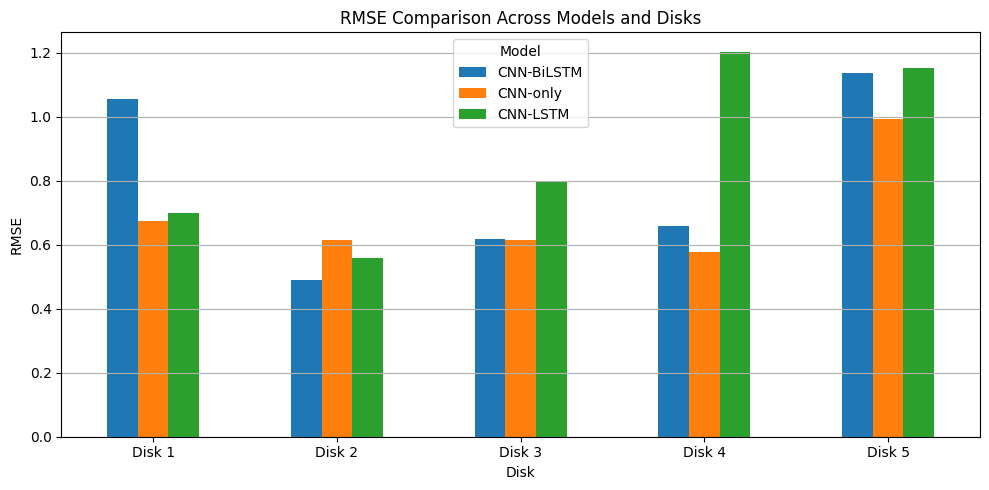

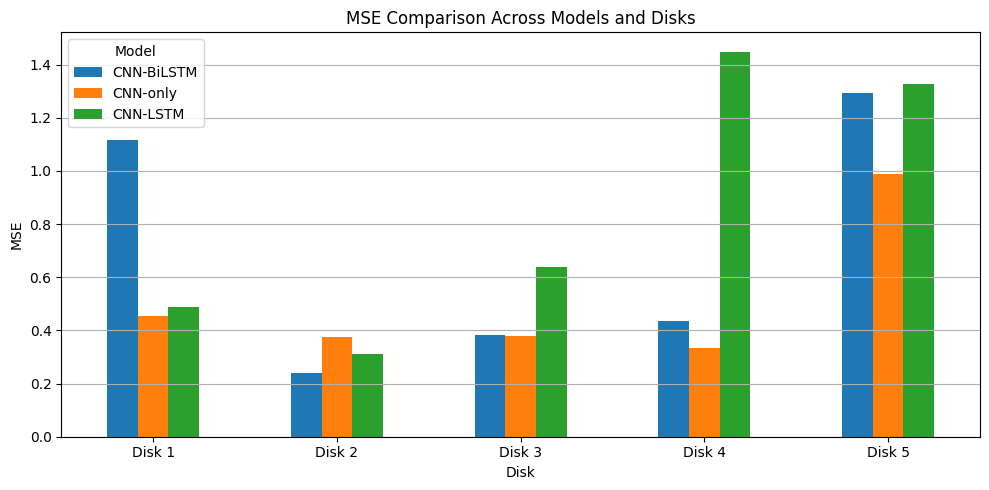

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# 결과 정의: RMSE와 R²는 주어졌고, MSE는 RMSE^2로 계산
models = ['CNN-BiLSTM', 'CNN-only', 'CNN-LSTM']
disks = ['Disk 1', 'Disk 2', 'Disk 3', 'Disk 4', 'Disk 5']

rmse_data = {
    'CNN-BiLSTM': [1.0569, 0.4912, 0.6192, 0.6590, 1.1367],
    'CNN-only':   [0.6754, 0.6137, 0.6146, 0.5789, 0.9942],
    'CNN-LSTM':   [0.6991, 0.5595, 0.7996, 1.2039, 1.1525]
}

# MSE = RMSE^2
mse_data = {
    model: [val**2 for val in rmse_data[model]]
    for model in models
}

# DataFrame 변환
rmse_df = pd.DataFrame(rmse_data, index=disks)
mse_df = pd.DataFrame(mse_data, index=disks)

# ----------------------------
# ✅ 그래프 1: RMSE 비교
# ----------------------------
rmse_df.plot(kind='bar', figsize=(10, 5))
plt.title('RMSE Comparison Across Models and Disks')
plt.ylabel('RMSE')
plt.xlabel('Disk')
plt.xticks(rotation=0)
plt.legend(title='Model')
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

# ----------------------------
# ✅ 그래프 2: MSE 비교
# ----------------------------
mse_df.plot(kind='bar', figsize=(10, 5))
plt.title('MSE Comparison Across Models and Disks')
plt.ylabel('MSE')
plt.xlabel('Disk')
plt.xticks(rotation=0)
plt.legend(title='Model')
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()


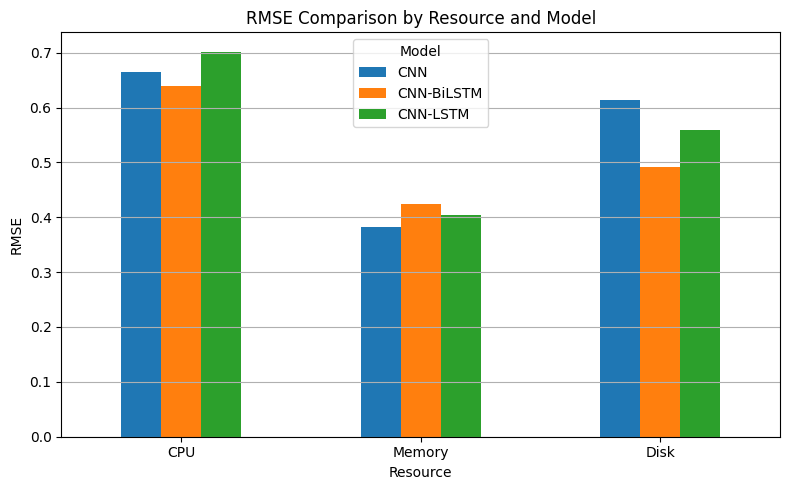

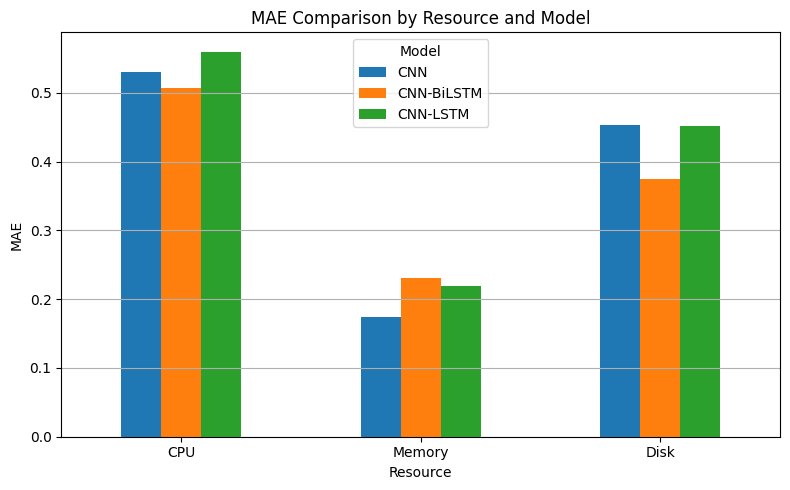

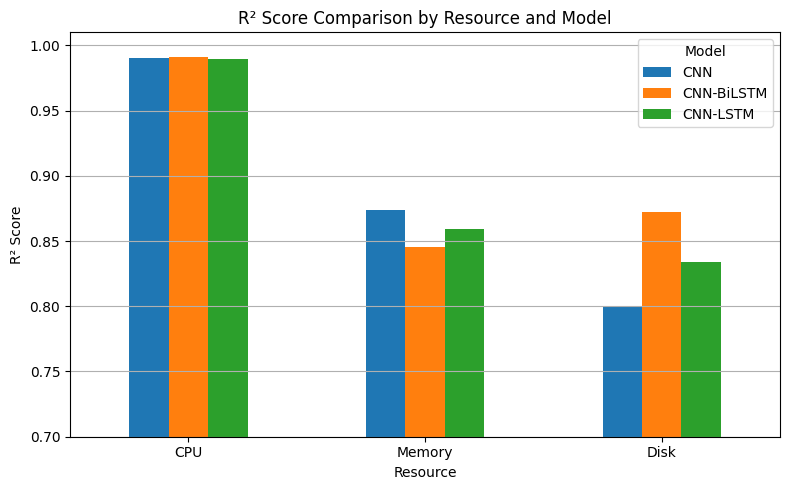

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# 리소스 / 모델
resources = ['CPU', 'Memory', 'Disk']
models = ['CNN', 'CNN-BiLSTM', 'CNN-LSTM']

# RMSE / MAE / R² 데이터
rmse_data = {
    'CPU': [0.6645, 0.6392, 0.7020],
    'Memory': [0.3825, 0.4233, 0.4042],
    'Disk': [0.6137, 0.4912, 0.5595]
}

mae_data = {
    'CPU': [0.5305, 0.5070, 0.5601],
    'Memory': [0.1738, 0.2306, 0.2190],
    'Disk': [0.4528, 0.3745, 0.4526]
}

r2_data = {
    'CPU': [0.9904, 0.9911, 0.9893],
    'Memory': [0.8736, 0.8452, 0.8590],
    'Disk': [0.8000, 0.8719, 0.8338]
}

# DataFrames
rmse_df = pd.DataFrame(rmse_data, index=models)
mae_df = pd.DataFrame(mae_data, index=models)
r2_df  = pd.DataFrame(r2_data,  index=models)

# ------------------- 그래프 1: RMSE -------------------
rmse_df.T.plot(kind='bar', figsize=(8,5))
plt.title('RMSE Comparison by Resource and Model')
plt.ylabel('RMSE')
plt.xlabel('Resource')
plt.xticks(rotation=0)
plt.legend(title='Model')
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

# ------------------- 그래프 2: MAE -------------------
mae_df.T.plot(kind='bar', figsize=(8,5))
plt.title('MAE Comparison by Resource and Model')
plt.ylabel('MAE')
plt.xlabel('Resource')
plt.xticks(rotation=0)
plt.legend(title='Model')
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

# ------------------- 그래프 3: R² -------------------
r2_df.T.plot(kind='bar', figsize=(8,5))
plt.title('R² Score Comparison by Resource and Model')
plt.ylabel('R² Score')
plt.xlabel('Resource')
plt.xticks(rotation=0)
plt.ylim(0.7, 1.01)  # 스케일 고정
plt.legend(title='Model')
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()


## app.py 에서 disk 함수만

In [ ]:

def show_disk_analysis():
        st.markdown("<h1 style='font-size:30px;'>📈 Memory 사용량 및 증설 판단</h1>", unsafe_allow_html=True)

        # 이상적인 데이터

        st.markdown("#### 1. 이상적인 데이터")

        with st.expander("학습모델 : CNN-LSTM"):
            st.markdown("#### 학습모델 : CNN-LSTM ")

            # 데이터 불러오기
            df_all_ideal = pd.read_csv("memory/Memory_all_series_CNN-LSTM.csv", index_col=0, parse_dates=True)
            df_pred_ideal = pd.read_csv("memory/Memory_usage_predicted_only_CNN-LSTM.csv", index_col=0, parse_dates=True)
            df_work_ideal = pd.read_csv("memory/Memory_usage_working_hours_CNN-LSTM.csv", index_col=0, parse_dates=True)
            df_peak_ideal = pd.read_csv("memory/Memory_peak_flag_per_day_CNN-LSTM.csv", index_col=0, parse_dates=True)

            avg_threshold = 75

            # 정확도
            with open("memory/Memory_accuracy_metrics_CNN-LSTM.json", "r") as f:
                metrics_ideal = json.load(f)

            # 결과 표시
            df_avg = pd.read_csv("memory/Memory_avg_usage_CNN-LSTM.csv")

            avg_work = df_avg[df_avg['type'] == 'work']['avg_usage'].values[0]
            avg_nowork = df_avg[df_avg['type'] == 'nowork']['avg_usage'].values[0]

            # 조건 재계산
            avg_memory_ideal = max(avg_work,avg_nowork) # 업무 비업무 중에 큰 avg 사용
            condition1_ideal = avg_memory_ideal >= avg_threshold

            series = pd.read_csv(
                "memory/Memory_all_series_CNN-LSTM.csv",
                index_col=0, parse_dates=True
            )['memory_usage']

            mu = float(series.mean())
            sigma = float(series.std())
            rel_threshold = mu + 2 * sigma

            daily_peak_flags = series > rel_threshold
            daily_peak = daily_peak_flags.groupby(series.index.date).any()
            peak_days = int(daily_peak.sum())
            total_days = int(len(daily_peak))
            condition2_flag = (peak_days / total_days) >= 0.07  # C등급 7%

            upgrade_ideal = condition1_ideal or condition2_flag

            st.markdown("#### ⚙️ 평균 Memory 사용률")
            st.markdown(f"- 업무시간 평균 사용률: **{avg_work:.1f}%**")
            st.markdown(f"- 비업무시간 평균 사용률: **{avg_nowork:.1f}%**")
            focus_period = "업무시간" if avg_work > avg_nowork else "비업무시간"
            focus_value = max(avg_work, avg_nowork)
            st.markdown(f"- 운영 집중 시간대: **{focus_period} ({focus_value:.1f}%)**")

            st.markdown("#### 📊 예측 정확도")
            st.markdown(f"- **MAE**: {metrics_ideal['MAE']}")
            st.markdown(f"- **RMSE**: {metrics_ideal['RMSE']}")
            st.markdown(f"- **R² Score**: {metrics_ideal['R2']}")

            st.markdown("#### 🔍 Memory 누설 판단")
            try:
                from scipy.stats import linregress
                _HAS_SCIPY = True
            except Exception:
                _HAS_SCIPY = False

            def detect_memory_leak_segmented(memory_df: pd.DataFrame,
                                            work_start="08:00",
                                            work_end="18:00",
                                            slope_threshold=0.0,
                                            min_points=5):
                """비업무 시간(18~익일 08시) 구간별 선형 회귀 기울기가 양수면 누수로 간주"""
                df = memory_df.copy()
                df.index = pd.to_datetime(df.index)
                df = df.sort_index()

                unique_days = pd.Index(sorted(pd.to_datetime(df.index.date).unique()))
                rows, leak_days = [], []

                ws_h = int(work_start.split(":")[0])  # 8
                we_h = int(work_end.split(":")[0])    # 18

                for d in unique_days[:-1]:  # 마지막 날은 다음날 08:00이 없을 수 있음
                    start = pd.Timestamp(d) + pd.Timedelta(hours=we_h)                  # d 18:00
                    end   = pd.Timestamp(d) + pd.Timedelta(days=1) + pd.Timedelta(hours=ws_h)  # d+1 08:00

                    seg = df.loc[(df.index >= start) & (df.index < end), "memory"]
                    if len(seg) < min_points:
                        continue

                    x = (seg.index - seg.index[0]).total_seconds() / 3600.0  # 시간 단위
                    y = seg.values.astype(float)

                    if _HAS_SCIPY:
                        slope, intercept, r, p, stderr = linregress(x, y)
                    else:
                        # SciPy 없는 환경 fallback
                        slope = np.polyfit(x, y, 1)[0]
                        r = np.corrcoef(x, y)[0, 1] if len(x) > 1 else np.nan
                        p = np.nan
                        stderr = np.nan

                    is_leak = slope > slope_threshold
                    rows.append({
                        "date": d,
                        "start": start,
                        "end": end,
                        "slope(%/h)": slope,
                        "r": r,
                        "p": p,
                        "is_leak": is_leak
                    })
                    if is_leak:
                        leak_days.append(d)

                detail = pd.DataFrame(rows)
                return {"is_memory_leak": len(leak_days) > 0, "leak_days": leak_days, "detail": detail}

            # --- 실행: 위에서 만든 series 사용 ---
            memory_df_for_leak = series.to_frame(name="memory")   # series: 전체 시계열 (index=datetime, column='memory_usage')
            memory_df_for_leak.rename(columns={"memory_usage": "memory"}, inplace=True)

            leak_res = detect_memory_leak_segmented(
                memory_df_for_leak,
                work_start="08:00",
                work_end="18:00",
                slope_threshold=0.0,  # 필요시 양수 조금(예: 0.01)로 조정
                min_points=5
            )

            is_leak = leak_res["is_memory_leak"]
            leak_days = leak_res["leak_days"]
            detail = leak_res["detail"]

            st.markdown(f"- **메모리 누수 감지 여부**: `{is_leak}` (감지 일수: **{len(leak_days)}**)")

            if not detail.empty:
                # 보기 좋게 포맷
                detail_show = detail.copy()
                detail_show["date"] = detail_show["date"].astype(str)
                detail_show = detail_show[["date", "start", "end", "slope(%/h)", "r", "p", "is_leak"]]
                st.dataframe(
                    detail_show.style.format({
                        "slope(%/h)": "{:.3f}",
                        "r": "{:.3f}",
                        "p": "{:.3f}"
                    }),
                    use_container_width=True
                )

            st.markdown("#### 🔍 증설 판단")
            st.markdown("#### 시스템 중요도 : C등급")
            st.markdown(f"<p style='font-size:18px'><b>조건 1.</b> (운영 집중 시간대 평균 사용률 ≥ 75%): <code>{condition1_ideal}</code> ({avg_memory_ideal:.2f}%)</p>", unsafe_allow_html=True)
            st.markdown(f"<p style='font-size:18px'><b>조건 2.</b> (전체 구간 대비 피크 발생 비율 ≥ 7%): <code>{condition2_flag}</code> ({int(peak_days)}/{total_days})</p>", unsafe_allow_html=True)

            result_text_ideal = '🟥 <b>증설 필요</b>' if upgrade_ideal else '🟩 <b>증설 불필요</b>'
            st.markdown(f"<h4>✅ 최종 판단: {result_text_ideal}</h3>", unsafe_allow_html=True)

            st.image("memory/Memory_plot_CNN-LSTM.png") # fig 파일


        # CNN
        with st.expander("학습모델 : CNN"):
            st.markdown("#### 학습모델 : CNN ")

            # 데이터 불러오기
            df_all_ideal = pd.read_csv("memory/Memory_all_series_CNN.csv", index_col=0, parse_dates=True)
            df_pred_ideal = pd.read_csv("memory/Memory_usage_predicted_only_CNN.csv", index_col=0, parse_dates=True)
            df_work_ideal = pd.read_csv("memory/Memory_usage_working_hours_CNN.csv", index_col=0, parse_dates=True)
            df_peak_ideal = pd.read_csv("memory/Memory_peak_flag_per_day_CNN.csv", index_col=0, parse_dates=True)

            avg_threshold = 75

            # 정확도
            with open("memory/Memory_accuracy_metrics_CNN.json", "r") as f:
                metrics_ideal = json.load(f)

            # 결과 표시
            df_avg = pd.read_csv("memory/Memory_avg_usage_CNN.csv")
            avg_work = df_avg[df_avg['type'] == 'work']['avg_usage'].values[0]
            avg_nowork = df_avg[df_avg['type'] == 'nowork']['avg_usage'].values[0]

            # 조건 재계산
            avg_memory_ideal = max(avg_work,avg_nowork) # 업무 비업무 중에 큰 avg 사용
            condition1_ideal = avg_memory_ideal >= avg_threshold

            series = pd.read_csv(
                "memory/Memory_all_series_CNN.csv",
                index_col=0, parse_dates=True
            )['memory_usage']

            mu = float(series.mean())
            sigma = float(series.std())
            rel_threshold = mu + 2 * sigma

            daily_peak_flags = series > rel_threshold
            daily_peak = daily_peak_flags.groupby(series.index.date).any()
            peak_days = int(daily_peak.sum())
            total_days = int(len(daily_peak))
            condition2_flag = (peak_days / total_days) >= 0.07  # C등급 7%

            upgrade_ideal = condition1_ideal or condition2_flag


            st.markdown("#### ⚙️ 평균 CPU 사용률")
            st.markdown(f"- 업무시간 평균 사용률: **{avg_work:.1f}%**")
            st.markdown(f"- 비업무시간 평균 사용률: **{avg_nowork:.1f}%**")
            focus_period = "업무시간" if avg_work > avg_nowork else "비업무시간"
            focus_value = max(avg_work, avg_nowork)
            st.markdown(f"- 운영 집중 시간대: **{focus_period} ({focus_value:.1f}%)**")

            st.markdown("#### 📊 예측 정확도")
            st.markdown(f"- **MAE**: {metrics_ideal['MAE']}")
            st.markdown(f"- **RMSE**: {metrics_ideal['RMSE']}")
            st.markdown(f"- **R² Score**: {metrics_ideal['R2']}")


            st.markdown("#### 🔍 Memory 누설 판단")
            try:
                from scipy.stats import linregress
                _HAS_SCIPY = True
            except Exception:
                _HAS_SCIPY = False

            def detect_memory_leak_segmented(memory_df: pd.DataFrame,
                                            work_start="08:00",
                                            work_end="18:00",
                                            slope_threshold=0.05,      # ← 기준 기울기( %/h )
                                            min_points=5,
                                            required_fraction=0.7):    # ← 전체 야간 중 만족 비율
                """비업무 시간(18~익일 08시)마다 선형회귀 기울기를 계산하고,
                  기울기 ≥ slope_threshold를 만족한 밤이 전체의 required_fraction 이상이면 누수로 판정."""
                df = memory_df.copy()
                df.index = pd.to_datetime(df.index)
                df = df.sort_index()

                unique_days = pd.Index(sorted(pd.to_datetime(df.index.date).unique()))
                rows, leak_days = [], []

                ws_h = int(work_start.split(":")[0])  # 8
                we_h = int(work_end.split(":")[0])    # 18

                nights_valid = 0
                nights_flagged = 0

                for d in unique_days[:-1]:  # 마지막 날은 다음날 08:00이 없을 수 있음
                    start = pd.Timestamp(d) + pd.Timedelta(hours=we_h)                  # d 18:00
                    end   = pd.Timestamp(d) + pd.Timedelta(days=1) + pd.Timedelta(hours=ws_h)  # d+1 08:00

                    seg = df.loc[(df.index >= start) & (df.index < end), "memory"]
                    if len(seg) < min_points:
                        continue

                    nights_valid += 1

                    x = (seg.index - seg.index[0]).total_seconds() / 3600.0  # 시간(시간 단위)
                    y = seg.values.astype(float)

                    try:
                        from scipy.stats import linregress
                        slope, intercept, r, p, stderr = linregress(x, y)
                    except Exception:
                        # SciPy 없는 환경 fallback
                        slope = np.polyfit(x, y, 1)[0]
                        r = np.corrcoef(x, y)[0, 1] if len(x) > 1 else np.nan
                        p = np.nan
                        stderr = np.nan

                    meets = slope >= slope_threshold
                    if meets:
                        nights_flagged += 1
                        leak_days.append(d)

                    rows.append({
                        "date": d,
                        "start": start,
                        "end": end,
                        "slope(%/h)": slope,
                        "r": r,
                        "p": p,
                        "meets_threshold": meets
                    })

                detail = pd.DataFrame(rows)
                leak_ratio = (nights_flagged / nights_valid) if nights_valid > 0 else 0.0
                is_memory_leak = leak_ratio >= required_fraction

                return {
                    "is_memory_leak": is_memory_leak,
                    "leak_days": leak_days,
                    "detail": detail,
                    "nights_valid": nights_valid,
                    "nights_flagged": nights_flagged,
                    "leak_ratio": leak_ratio
                }


            # --- 실행: 위에서 만든 series 사용 ---
            memory_df_for_leak = series.to_frame(name="memory")   # series: 전체 시계열
            leak_res = detect_memory_leak_segmented(
                memory_df_for_leak,
                work_start="08:00",
                work_end="18:00",
                slope_threshold=0.05,   # 기울기 기준
                min_points=5,
                required_fraction=0.7   # 야간의 70% 이상
            )

            is_leak   = leak_res["is_memory_leak"]
            detail    = leak_res["detail"]
            ratio_pct = leak_res["leak_ratio"] * 100

            st.markdown(
                f"- **메모리 누수 감지 여부**: `{is_leak}` "
                f"(기준 충족 밤: **{leak_res['nights_flagged']}/{leak_res['nights_valid']}**, "
                f"비율: **{ratio_pct:.1f}%**)"
            )
            if not detail.empty:
                st.dataframe(detail.style.format({"slope(%/h)": "{:.3f}", "r": "{:.3f}", "p": "{:.3f}"}),
                            use_container_width=True)


            st.markdown("#### 🔍 증설 판단")
            st.markdown("#### 시스템 중요도 : C등급")
            st.markdown(f"<p style='font-size:18px'><b>조건 1.</b> (운영 집중 시간대 평균 사용률 ≥ 75%): <code>{condition1_ideal}</code> ({avg_memory_ideal:.2f}%)</p>", unsafe_allow_html=True)
            st.markdown(f"<p style='font-size:18px'><b>조건 2.</b> (전체 구간 대비 피크 발생 비율 ≥ 7%): <code>{condition2_flag}</code> ({int(peak_days)}/{total_days})</p>", unsafe_allow_html=True)

            result_text_ideal = '🟥 <b>증설 필요</b>' if upgrade_ideal else '🟩 <b>증설 불필요</b>'
            st.markdown(f"<h4>✅ 최종 판단: {result_text_ideal}</h3>", unsafe_allow_html=True)

            st.image("memory/Memory_plot_CNN.png") # fig 파일

        ## Bi-LSTM
        with st.expander("학습모델 : Bi-LSTM"):
            st.markdown("#### 학습모델 : Bi-LSTM ")

            # 데이터 불러오기
            df_all_ideal = pd.read_csv("memory/Memory_all_series_Bi-LSTM.csv", index_col=0, parse_dates=True)
            df_pred_ideal = pd.read_csv("memory/Memory_usage_predicted_only_Bi-LSTM.csv", index_col=0, parse_dates=True)
            df_work_ideal = pd.read_csv("memory/Memory_usage_working_hours_Bi-LSTM.csv", index_col=0, parse_dates=True)
            df_peak_ideal = pd.read_csv("memory/Memory_peak_flag_per_day_Bi-LSTM.csv", index_col=0, parse_dates=True)

            avg_threshold = 75

            # 조건 재계산
            avg_memory_ideal = df_work_ideal.values.mean()
            condition1_ideal = avg_memory_ideal >= avg_threshold

            peak_days_ideal = df_peak_ideal.values.sum()
            total_days_ideal = len(df_peak_ideal)
            condition2_ideal = (peak_days_ideal / total_days_ideal) >= 0.8

            upgrade_ideal = condition1_ideal or condition2_ideal

            # 정확도
            with open("cpu/cpu_accuracy_metrics_Bi-LSTM.json", "r") as f:
                metrics_ideal = json.load(f)

            # 결과 표시
            df_avg = pd.read_csv("cpu/cpu_avg_usage_Bi-LSTM.csv")
            avg_work = df_avg[df_avg['type'] == 'work']['avg_usage'].values[0]
            avg_nowork = df_avg[df_avg['type'] == 'nowork']['avg_usage'].values[0]

            # 조건 재계산
            avg_cpu_ideal = max(avg_work,avg_nowork) # 업무 비업무 중에 큰 avg 사용
            condition1_ideal = avg_cpu_ideal >= avg_threshold

            series = pd.read_csv(
                "memory/Memory_all_series_Bi-LSTM.csv",
                index_col=0, parse_dates=True
            )['memory_usage']

            mu = float(series.mean())
            sigma = float(series.std())
            rel_threshold = mu + 2 * sigma

            daily_peak_flags = series > rel_threshold
            daily_peak = daily_peak_flags.groupby(series.index.date).any()
            peak_days = int(daily_peak.sum())
            total_days = int(len(daily_peak))
            condition2_flag = (peak_days / total_days) >= 0.07  # C등급 7%

            upgrade_ideal = condition1_ideal or condition2_flag


            st.markdown("#### ⚙️ 평균 CPU 사용률")
            st.markdown(f"- 업무시간 평균 사용률: **{avg_work:.1f}%**")
            st.markdown(f"- 비업무시간 평균 사용률: **{avg_nowork:.1f}%**")
            focus_period = "업무시간" if avg_work > avg_nowork else "비업무시간"
            focus_value = max(avg_work, avg_nowork)
            st.markdown(f"- 운영 집중 시간대: **{focus_period} ({focus_value:.1f}%)**")

            st.markdown("#### 📊 예측 정확도")
            st.markdown(f"- **MAE**: {metrics_ideal['MAE']}")
            st.markdown(f"- **RMSE**: {metrics_ideal['RMSE']}")
            st.markdown(f"- **R² Score**: {metrics_ideal['R2']}")


            st.markdown("#### 🔍 Memory 누설 판단")
            try:
                from scipy.stats import linregress
                _HAS_SCIPY = True
            except Exception:
                _HAS_SCIPY = False

            def detect_memory_leak_segmented(memory_df: pd.DataFrame,
                                            work_start="08:00",
                                            work_end="18:00",
                                            slope_threshold=0.05,      # ← 기준 기울기( %/h )
                                            min_points=5,
                                            required_fraction=0.7):    # ← 전체 야간 중 만족 비율
                """비업무 시간(18~익일 08시)마다 선형회귀 기울기를 계산하고,
                  기울기 ≥ slope_threshold를 만족한 밤이 전체의 required_fraction 이상이면 누수로 판정."""
                df = memory_df.copy()
                df.index = pd.to_datetime(df.index)
                df = df.sort_index()

                unique_days = pd.Index(sorted(pd.to_datetime(df.index.date).unique()))
                rows, leak_days = [], []

                ws_h = int(work_start.split(":")[0])  # 8
                we_h = int(work_end.split(":")[0])    # 18

                nights_valid = 0
                nights_flagged = 0

                for d in unique_days[:-1]:  # 마지막 날은 다음날 08:00이 없을 수 있음
                    start = pd.Timestamp(d) + pd.Timedelta(hours=we_h)                  # d 18:00
                    end   = pd.Timestamp(d) + pd.Timedelta(days=1) + pd.Timedelta(hours=ws_h)  # d+1 08:00

                    seg = df.loc[(df.index >= start) & (df.index < end), "memory"]
                    if len(seg) < min_points:
                        continue

                    nights_valid += 1

                    x = (seg.index - seg.index[0]).total_seconds() / 3600.0  # 시간(시간 단위)
                    y = seg.values.astype(float)

                    try:
                        from scipy.stats import linregress
                        slope, intercept, r, p, stderr = linregress(x, y)
                    except Exception:
                        # SciPy 없는 환경 fallback
                        slope = np.polyfit(x, y, 1)[0]
                        r = np.corrcoef(x, y)[0, 1] if len(x) > 1 else np.nan
                        p = np.nan
                        stderr = np.nan

                    meets = slope >= slope_threshold
                    if meets:
                        nights_flagged += 1
                        leak_days.append(d)

                    rows.append({
                        "date": d,
                        "start": start,
                        "end": end,
                        "slope(%/h)": slope,
                        "r": r,
                        "p": p,
                        "meets_threshold": meets
                    })

                detail = pd.DataFrame(rows)
                leak_ratio = (nights_flagged / nights_valid) if nights_valid > 0 else 0.0
                is_memory_leak = leak_ratio >= required_fraction

                return {
                    "is_memory_leak": is_memory_leak,
                    "leak_days": leak_days,
                    "detail": detail,
                    "nights_valid": nights_valid,
                    "nights_flagged": nights_flagged,
                    "leak_ratio": leak_ratio
                }

            # --- 실행: 위에서 만든 series 사용 ---
            memory_df_for_leak = series.to_frame(name="memory")   # series: 전체 시계열
            leak_res = detect_memory_leak_segmented(
                memory_df_for_leak,
                work_start="08:00",
                work_end="18:00",
                slope_threshold=0.05,   # 기울기 기준
                min_points=5,
                required_fraction=0.7   # 야간의 70% 이상
            )

            is_leak   = leak_res["is_memory_leak"]
            detail    = leak_res["detail"]
            ratio_pct = leak_res["leak_ratio"] * 100

            st.markdown(
                f"- **메모리 누수 감지 여부**: `{is_leak}` "
                f"(기준 충족 밤: **{leak_res['nights_flagged']}/{leak_res['nights_valid']}**, "
                f"비율: **{ratio_pct:.1f}%**)"
            )
            if not detail.empty:
                st.dataframe(detail.style.format({"slope(%/h)": "{:.3f}", "r": "{:.3f}", "p": "{:.3f}"}),
                            use_container_width=True)


            st.markdown("#### 🔍 증설 판단")
            st.markdown("#### 시스템 중요도 : C등급")
            st.markdown(f"<p style='font-size:18px'><b>조건 1.</b> (운영 집중 시간대 평균 사용률 ≥ 75%): <code>{condition1_ideal}</code> ({avg_memory_ideal:.2f}%)</p>", unsafe_allow_html=True)
            st.markdown(f"<p style='font-size:18px'><b>조건 2.</b> (전체 구간 대비 피크 발생 비율 ≥ 7%): <code>{condition2_flag}</code> ({int(peak_days)}/{total_days})</p>", unsafe_allow_html=True)

            result_text_ideal = '🟥 <b>증설 필요</b>' if upgrade_ideal else '🟩 <b>증설 불필요</b>'
            st.markdown(f"<h4>✅ 최종 판단: {result_text_ideal}</h3>", unsafe_allow_html=True)

            st.image("memory/Memory_plot_Bi-LSTM.png") # fig 파일


        # 2. 노이즈 많은 데이터

        # --- 파일 불러오기 ---
        df_all = pd.read_csv("memory/Memory_all_series_CNN-LSTM2.csv", index_col=0, parse_dates=True)
        df_pred = pd.read_csv("memory/Memory_usage_predicted_only_CNN-LSTM2.csv", index_col=0, parse_dates=True)
        df_work = pd.read_csv("memory/Memory_usage_working_hours_CNN-LSTM2.csv", index_col=0, parse_dates=True)
        df_peak = pd.read_csv("memory/Memory_peak_flag_per_day_CNN-LSTM2.csv", index_col=0, parse_dates=True)


        # --- 조건 재계산 ---
        avg_threshold = 80

        avg_cpu = df_work.values.mean()
        condition1_flag = avg_cpu >= avg_threshold

        peak_days = df_peak.values.sum()
        total_days = len(df_peak)
        condition2_flag = (peak_days / total_days) >= 0.8

        upgrade_flag = condition1_flag or condition2_flag

        from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

        # 정확도 불러오기
        with open("cpu/cpu_accuracy_metrics_CNN-LSTM2.json", "r") as f:
            metrics = json.load(f)

        # --- 업그레이드 표시 시간 추출 ---
        if condition1_flag:
            upgrade_times = df_work.index
        elif condition2_flag:
            peak_day_list = df_peak[df_peak.values.flatten()].index[:5]
            upgrade_times = df_work[df_work.index.date.astype(str).isin(peak_day_list.astype(str))].index
        else:
            upgrade_times = []

        # --- Streamlit 출력 ---

        st.markdown("#### 2. 노이즈 많은 데이터")
        with st.expander("학습모델 : CNN-LSTM"):
          st.markdown("#### 학습모델 : CNN-LSTM")

          # 표시
          df_avg = pd.read_csv("cpu/cpu_avg_usage_CNN-LSTM2.csv")
          avg_work = df_avg[df_avg['type'] == 'work']['avg_usage'].values[0]
          avg_nowork = df_avg[df_avg['type'] == 'nowork']['avg_usage'].values[0]

          # 조건 재계산
          avg_cpu_ideal = max(avg_work,avg_nowork) # 업무 비업무 중에 큰 avg 사용
          condition1_ideal = avg_cpu_ideal >= avg_threshold

          peak_days_ideal = df_peak_ideal.values.sum()
          total_days_ideal = len(df_peak_ideal)
          condition2_ideal = (peak_days_ideal / total_days_ideal) >= 0.8

          upgrade_ideal = condition1_ideal or condition2_ideal

          st.markdown("#### ⚙️ 평균 CPU 사용률")
          st.markdown(f"- 업무시간 평균 사용률: **{avg_work:.1f}%**")
          st.markdown(f"- 비업무시간 평균 사용률: **{avg_nowork:.1f}%**")
          focus_period = "업무시간" if avg_work > avg_nowork else "비업무시간"
          focus_value = max(avg_work, avg_nowork)
          st.markdown(f"- 운영 집중 시간대: **{focus_period} ({focus_value:.1f}%)**")

          st.markdown("#### 📊 예측 정확도")
          st.markdown(f"- **MAE**: {metrics['MAE']}")
          st.markdown(f"- **RMSE**: {metrics['RMSE']}")
          st.markdown(f"- **R² Score**: {metrics['R2']}")

          st.markdown("#### 🔍 증설 판단")
          st.markdown("#### 시스템 중요도 : A등급")
          st.markdown(f"<p style='font-size:18px'><b>조건 1.</b> (운영 집중 시간대 평균 CPU 사용량 ≥ 70%): <code>{condition1_flag}</code> ({avg_cpu:.2f}%)</p>", unsafe_allow_html=True)
          st.markdown(f"<p style='font-size:18px'><b>조건 2.</b> (전체 구간 대비 피크 발생 비율): <code>{condition2_flag}</code> ({int(peak_days)}/{total_days})</p>", unsafe_allow_html=True)

          # 결과 강조
          result_text = '🟥 <b>증설 필요</b>' if upgrade_flag else '🟩 <b>증설 불필요</b>'
          st.markdown(f"<h4>✅ 최종 판단: {result_text}</h3>", unsafe_allow_html=True)
          st.image("cpu/cpu_plot_CNN-LSTM2.png") # fig 파일

        # CNN
        with st.expander("학습모델 : CNN"):
          st.markdown("#### 학습모델 : CNN")

          # --- 파일 불러오기 ---
          df_all = pd.read_csv("cpu/all_series_CNN2.csv", index_col=0, parse_dates=True)
          df_pred = pd.read_csv("cpu/cpu_usage_predicted_only_CNN2.csv", index_col=0, parse_dates=True)
          df_work = pd.read_csv("cpu/cpu_usage_working_hours_CNN2.csv", index_col=0, parse_dates=True)
          df_peak = pd.read_csv("cpu/cpu_peak_flag_per_day_CNN2.csv", index_col=0, parse_dates=True)

          from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

          # 정확도 불러오기
          with open("cpu/cpu_accuracy_metrics_CNN2.json", "r") as f:
              metrics = json.load(f)

          # 표시
          df_avg = pd.read_csv("cpu/cpu_avg_usage_CNN2.csv")
          avg_work = df_avg[df_avg['type'] == 'work']['avg_usage'].values[0]
          avg_nowork = df_avg[df_avg['type'] == 'nowork']['avg_usage'].values[0]

          # 조건 재계산
          avg_cpu_ideal = max(avg_work,avg_nowork) # 업무 비업무 중에 큰 avg 사용
          condition1_ideal = avg_cpu_ideal >= avg_threshold

          peak_days_ideal = df_peak_ideal.values.sum()
          total_days_ideal = len(df_peak_ideal)
          condition2_ideal = (peak_days_ideal / total_days_ideal) >= 0.8

          upgrade_ideal = condition1_ideal or condition2_ideal

          st.markdown("#### ⚙️ 평균 CPU 사용률")
          st.markdown(f"- 업무시간 평균 사용률: **{avg_work:.1f}%**")
          st.markdown(f"- 비업무시간 평균 사용률: **{avg_nowork:.1f}%**")
          focus_period = "업무시간" if avg_work > avg_nowork else "비업무시간"
          focus_value = max(avg_work, avg_nowork)
          st.markdown(f"- 운영 집중 시간대: **{focus_period} ({focus_value:.1f}%)**")

          st.markdown("#### 📊 예측 정확도")
          st.markdown(f"- **MAE**: {metrics['MAE']}")
          st.markdown(f"- **RMSE**: {metrics['RMSE']}")
          st.markdown(f"- **R² Score**: {metrics['R2']}")

          st.markdown("#### 🔍 증설 판단")
          st.markdown("#### 시스템 중요도 : A등급")
          st.markdown(f"<p style='font-size:18px'><b>조건 1.</b> (운영 집중 시간대 평균 CPU 사용량 ≥ 70%): <code>{condition1_flag}</code> ({avg_cpu:.2f}%)</p>", unsafe_allow_html=True)
          st.markdown(f"<p style='font-size:18px'><b>조건 2.</b> (전체 구간 대비 피크 발생 비율): <code>{condition2_flag}</code> ({int(peak_days)}/{total_days})</p>", unsafe_allow_html=True)

          # 결과 강조
          result_text = '🟥 <b>증설 필요</b>' if upgrade_flag else '🟩 <b>증설 불필요</b>'
          st.markdown(f"<h4>✅ 최종 판단: {result_text}</h3>", unsafe_allow_html=True)

          st.image("cpu/cpu_plot_CNN2.png") # fig 파일


        # Bi-LSTM
        with st.expander("학습모델 : Bi-LSTM"):
            st.markdown("#### 학습모델 : Bi-LSTM")

            # 데이터 불러오기
            df_all_ideal = pd.read_csv("cpu/all_series_Bi-LSTM2.csv", index_col=0, parse_dates=True)
            df_pred_ideal = pd.read_csv("cpu/cpu_usage_predicted_only_Bi-LSTM2.csv", index_col=0, parse_dates=True)
            df_work_ideal = pd.read_csv("cpu/cpu_usage_working_hours_Bi-LSTM2.csv", index_col=0, parse_dates=True)
            df_peak_ideal = pd.read_csv("cpu/cpu_peak_flag_per_day_Bi-LSTM2.csv", index_col=0, parse_dates=True)

            avg_threshold = 80
            peak_threshold = 90

            # 조건 재계산
            avg_cpu_ideal = df_work_ideal.values.mean()
            condition1_ideal = avg_cpu_ideal >= avg_threshold

            peak_days_ideal = df_peak_ideal.values.sum()
            total_days_ideal = len(df_peak_ideal)
            condition2_ideal = (peak_days_ideal / total_days_ideal) >= 0.8

            upgrade_ideal = condition1_ideal or condition2_ideal

            # 정확도
            with open("cpu/cpu_accuracy_metrics_Bi-LSTM2.json", "r") as f:
                metrics_ideal = json.load(f)

            # 결과 표시
            df_avg = pd.read_csv("cpu/cpu_avg_usage_Bi-LSTM2.csv")
            avg_work = df_avg[df_avg['type'] == 'work']['avg_usage'].values[0]
            avg_nowork = df_avg[df_avg['type'] == 'nowork']['avg_usage'].values[0]

            # 조건 재계산
            avg_cpu_ideal = max(avg_work,avg_nowork) # 업무 비업무 중에 큰 avg 사용
            condition1_ideal = avg_cpu_ideal >= avg_threshold

            peak_days_ideal = df_peak_ideal.values.sum()
            total_days_ideal = len(df_peak_ideal)
            condition2_ideal = (peak_days_ideal / total_days_ideal) >= 0.8

            upgrade_ideal = condition1_ideal or condition2_ideal

            st.markdown("#### ⚙️ 평균 CPU 사용률")
            st.markdown(f"- 업무시간 평균 사용률: **{avg_work:.1f}%**")
            st.markdown(f"- 비업무시간 평균 사용률: **{avg_nowork:.1f}%**")
            focus_period = "업무시간" if avg_work > avg_nowork else "비업무시간"
            focus_value = max(avg_work, avg_nowork)
            st.markdown(f"- 운영 집중 시간대: **{focus_period} ({focus_value:.1f}%)**")

            st.markdown("#### 📊 예측 정확도")
            st.markdown(f"- **MAE**: {metrics_ideal['MAE']}")
            st.markdown(f"- **RMSE**: {metrics_ideal['RMSE']}")
            st.markdown(f"- **R² Score**: {metrics_ideal['R2']}")

            st.markdown("#### 🔍 증설 판단")
            st.markdown("#### 시스템 중요도 : A등급")
            st.markdown(f"<p style='font-size:18px'><b>조건 1.</b> (운영 집중 시간대 평균 사용률 ≥ 70%): <code>{condition1_ideal}</code> ({avg_cpu_ideal:.2f}%)</p>", unsafe_allow_html=True)
            st.markdown(f"<p style='font-size:18px'><b>조건 2.</b> (전체 구간 대비 피크 발생 비율 ≥ 80%): <code>{condition2_ideal}</code> ({int(peak_days_ideal)}/{total_days_ideal})</p>", unsafe_allow_html=True)

            result_text_ideal = '🟥 <b>증설 필요</b>' if upgrade_ideal else '🟩 <b>증설 불필요</b>'
            st.markdown(f"<h4>✅ 최종 판단: {result_text_ideal}</h3>", unsafe_allow_html=True)

            st.image("cpu/cpu_plot_Bi-LSTM2.png") # fig 파일

      # 3. 증설 필요한 데이터

        st.markdown("#### 3. 증설 필요한 데이터")

        with st.expander("학습모델 : CNN-LSTM"):
            st.markdown("#### 학습모델 : CNN-LSTM ")

            # 데이터 불러오기
            df_all_ideal = pd.read_csv("cpu/all_series_CNN-LSTM3.csv", index_col=0, parse_dates=True)
            df_pred_ideal = pd.read_csv("cpu/cpu_usage_predicted_only_CNN-LSTM3.csv", index_col=0, parse_dates=True)
            df_work_ideal = pd.read_csv("cpu/cpu_usage_working_hours_CNN-LSTM3.csv", index_col=0, parse_dates=True)
            df_peak_ideal = pd.read_csv("cpu/cpu_peak_flag_per_day_CNN-LSTM3.csv", index_col=0, parse_dates=True)

            avg_threshold = 80
            peak_threshold = 90

            # 정확도
            with open("cpu/cpu_accuracy_metrics_CNN-LSTM3.json", "r") as f:
                metrics_ideal = json.load(f)

            # 결과 표시
            df_avg = pd.read_csv("cpu/cpu_avg_usage_CNN-LSTM3.csv")

            avg_work = df_avg[df_avg['type'] == 'work']['avg_usage'].values[0]
            avg_nowork = df_avg[df_avg['type'] == 'nowork']['avg_usage'].values[0]

            # 조건 재계산
            avg_cpu_ideal = max(avg_work,avg_nowork) # 업무 비업무 중에 큰 avg 사용
            condition1_ideal = avg_cpu_ideal >= avg_threshold

            peak_days_ideal = df_peak_ideal.values.sum()
            total_days_ideal = len(df_peak_ideal)
            condition2_ideal = (peak_days_ideal / total_days_ideal) >= 0.8

            upgrade_ideal = condition1_ideal or condition2_ideal

            st.markdown("#### ⚙️ 평균 CPU 사용률")
            st.markdown(f"- 업무시간 평균 사용률: **{avg_work:.1f}%**")
            st.markdown(f"- 비업무시간 평균 사용률: **{avg_nowork:.1f}%**")
            focus_period = "업무시간" if avg_work > avg_nowork else "비업무시간"
            focus_value = max(avg_work, avg_nowork)
            st.markdown(f"- 운영 집중 시간대: **{focus_period} ({focus_value:.1f}%)**")

            st.markdown("#### 📊 예측 정확도")
            st.markdown(f"- **MAE**: {metrics_ideal['MAE']}")
            st.markdown(f"- **RMSE**: {metrics_ideal['RMSE']}")
            st.markdown(f"- **R² Score**: {metrics_ideal['R2']}")

            st.markdown("#### 🔍 증설 판단")
            st.markdown("#### 시스템 중요도 : A등급")
            st.markdown(f"<p style='font-size:18px'><b>조건 1.</b> (운영 집중 시간대 평균 사용률 ≥ 70%): <code>{condition1_ideal}</code> ({avg_cpu_ideal:.2f}%)</p>", unsafe_allow_html=True)
            st.markdown(f"<p style='font-size:18px'><b>조건 2.</b> (전체 구간 대비 피크 발생 비율 ≥ 80%): <code>{condition2_ideal}</code> ({int(peak_days_ideal)}/{total_days_ideal})</p>", unsafe_allow_html=True)

            result_text_ideal = '🟥 <b>증설 필요</b>' if upgrade_ideal else '🟩 <b>증설 불필요</b>'
            st.markdown(f"<h4>✅ 최종 판단: {result_text_ideal}</h3>", unsafe_allow_html=True)

            st.image("cpu/cpu_plot_CNN-LSTM3.png") # fig 파일

        # CNN
        with st.expander("학습모델 : CNN"):
            st.markdown("#### 학습모델 : CNN ")

            # 데이터 불러오기
            df_all_ideal = pd.read_csv("cpu/all_series_CNN3.csv", index_col=0, parse_dates=True)
            df_pred_ideal = pd.read_csv("cpu/cpu_usage_predicted_only_CNN3.csv", index_col=0, parse_dates=True)
            df_work_ideal = pd.read_csv("cpu/cpu_usage_working_hours_CNN3.csv", index_col=0, parse_dates=True)
            df_peak_ideal = pd.read_csv("cpu/cpu_peak_flag_per_day_CNN3.csv", index_col=0, parse_dates=True)

            avg_threshold = 80
            peak_threshold = 90

            # 정확도
            with open("cpu/cpu_accuracy_metrics_CNN3.json", "r") as f:
                metrics_ideal = json.load(f)

            # 결과 표시
            df_avg = pd.read_csv("cpu/cpu_avg_usage_CNN3.csv")
            avg_work = df_avg[df_avg['type'] == 'work']['avg_usage'].values[0]
            avg_nowork = df_avg[df_avg['type'] == 'nowork']['avg_usage'].values[0]

            # 조건 재계산
            avg_cpu_ideal = max(avg_work,avg_nowork) # 업무 비업무 중에 큰 avg 사용
            condition1_ideal = avg_cpu_ideal >= avg_threshold

            peak_days_ideal = df_peak_ideal.values.sum()
            total_days_ideal = len(df_peak_ideal)
            condition2_ideal = (peak_days_ideal / total_days_ideal) >= 0.8

            upgrade_ideal = condition1_ideal or condition2_ideal

            st.markdown("#### ⚙️ 평균 CPU 사용률")
            st.markdown(f"- 업무시간 평균 사용률: **{avg_work:.1f}%**")
            st.markdown(f"- 비업무시간 평균 사용률: **{avg_nowork:.1f}%**")
            focus_period = "업무시간" if avg_work > avg_nowork else "비업무시간"
            focus_value = max(avg_work, avg_nowork)
            st.markdown(f"- 운영 집중 시간대: **{focus_period} ({focus_value:.1f}%)**")

            st.markdown("#### 📊 예측 정확도")
            st.markdown(f"- **MAE**: {metrics_ideal['MAE']}")
            st.markdown(f"- **RMSE**: {metrics_ideal['RMSE']}")
            st.markdown(f"- **R² Score**: {metrics_ideal['R2']}")

            st.markdown("#### 🔍 증설 판단")
            st.markdown("#### 시스템 중요도 : A등급")
            st.markdown(f"<p style='font-size:18px'><b>조건 1.</b> (운영 집중 시간대 평균 사용률 ≥ 70%): <code>{condition1_ideal}</code> ({avg_cpu_ideal:.2f}%)</p>", unsafe_allow_html=True)
            st.markdown(f"<p style='font-size:18px'><b>조건 2.</b> (전체 구간 대비 피크 발생 비율 ≥ 80%): <code>{condition2_ideal}</code> ({int(peak_days_ideal)}/{total_days_ideal})</p>", unsafe_allow_html=True)

            result_text_ideal = '🟥 <b>증설 필요</b>' if upgrade_ideal else '🟩 <b>증설 불필요</b>'
            st.markdown(f"<h4>✅ 최종 판단: {result_text_ideal}</h3>", unsafe_allow_html=True)
            st.image("cpu/cpu_plot_CNN3.png") # fig 파일

        ## Bi-LSTM
        with st.expander("학습모델 : Bi-LSTM"):
            st.markdown("#### 학습모델 : Bi-LSTM ")

            # 데이터 불러오기
            df_all_ideal = pd.read_csv("cpu/all_series_Bi-LSTM3.csv", index_col=0, parse_dates=True)
            df_pred_ideal = pd.read_csv("cpu/cpu_usage_predicted_only_Bi-LSTM3.csv", index_col=0, parse_dates=True)
            df_work_ideal = pd.read_csv("cpu/cpu_usage_working_hours_Bi-LSTM3.csv", index_col=0, parse_dates=True)
            df_peak_ideal = pd.read_csv("cpu/cpu_peak_flag_per_day_Bi-LSTM3.csv", index_col=0, parse_dates=True)

            avg_threshold = 80
            peak_threshold = 90

            # 조건 재계산
            avg_cpu_ideal = df_work_ideal.values.mean()
            condition1_ideal = avg_cpu_ideal >= avg_threshold

            peak_days_ideal = df_peak_ideal.values.sum()
            total_days_ideal = len(df_peak_ideal)
            condition2_ideal = (peak_days_ideal / total_days_ideal) >= 0.8

            upgrade_ideal = condition1_ideal or condition2_ideal

            # 정확도
            with open("cpu/cpu_accuracy_metrics_Bi-LSTM3.json", "r") as f:
                metrics_ideal = json.load(f)

            # 결과 표시
            df_avg = pd.read_csv("cpu/cpu_avg_usage_Bi-LSTM3.csv")
            avg_work = df_avg[df_avg['type'] == 'work']['avg_usage'].values[0]
            avg_nowork = df_avg[df_avg['type'] == 'nowork']['avg_usage'].values[0]

            # 조건 재계산
            avg_cpu_ideal = max(avg_work,avg_nowork) # 업무 비업무 중에 큰 avg 사용
            condition1_ideal = avg_cpu_ideal >= avg_threshold

            peak_days_ideal = df_peak_ideal.values.sum()
            total_days_ideal = len(df_peak_ideal)
            condition2_ideal = (peak_days_ideal / total_days_ideal) >= 0.8

            upgrade_ideal = condition1_ideal or condition2_ideal

            st.markdown("#### ⚙️ 평균 CPU 사용률")
            st.markdown(f"- 업무시간 평균 사용률: **{avg_work:.1f}%**")
            st.markdown(f"- 비업무시간 평균 사용률: **{avg_nowork:.1f}%**")
            focus_period = "업무시간" if avg_work > avg_nowork else "비업무시간"
            focus_value = max(avg_work, avg_nowork)
            st.markdown(f"- 운영 집중 시간대: **{focus_period} ({focus_value:.1f}%)**")

            st.markdown("#### 📊 예측 정확도")
            st.markdown(f"- **MAE**: {metrics_ideal['MAE']}")
            st.markdown(f"- **RMSE**: {metrics_ideal['RMSE']}")
            st.markdown(f"- **R² Score**: {metrics_ideal['R2']}")

            st.markdown("#### 🔍 증설 판단")
            st.markdown("#### 시스템 중요도 : A등급")
            st.markdown(f"<p style='font-size:18px'><b>조건 1.</b> (운영 집중 시간대 평균 사용률 ≥ 70%): <code>{condition1_ideal}</code> ({avg_cpu_ideal:.2f}%)</p>", unsafe_allow_html=True)
            st.markdown(f"<p style='font-size:18px'><b>조건 2.</b> (전체 구간 대비 피크 발생 비율 ≥ 80%): <code>{condition2_ideal}</code> ({int(peak_days_ideal)}/{total_days_ideal})</p>", unsafe_allow_html=True)

            result_text_ideal = '🟥 <b>증설 필요</b>' if upgrade_ideal else '🟩 <b>증설 불필요</b>'
            st.markdown(f"<h4>✅ 최종 판단: {result_text_ideal}</h3>", unsafe_allow_html=True)

            st.image("cpu/cpu_plot_Bi-LSTM3.png") # fig 파일

      # 4. 축소 필요한 데이터

        st.markdown("#### 4. 증설 필요한 데이터")

        with st.expander("학습모델 : CNN-LSTM"):
            st.markdown("#### 학습모델 : CNN-LSTM ")

            # 데이터 불러오기
            df_all_ideal = pd.read_csv("cpu/all_series_CNN-LSTM4.csv", index_col=0, parse_dates=True)
            df_pred_ideal = pd.read_csv("cpu/cpu_usage_predicted_only_CNN-LSTM4.csv", index_col=0, parse_dates=True)
            df_work_ideal = pd.read_csv("cpu/cpu_usage_working_hours_CNN-LSTM4.csv", index_col=0, parse_dates=True)

            avg_threshold = 30
            std_threshold = 5  # C등급 기준: 표준편차 5% 이하

            # 평균 사용률 조건
            avg_cpu_ideal = max(avg_work, avg_nowork)
            condition1_ideal = avg_cpu_ideal <= avg_threshold

            # 표준편차 계산
            std_cpu_ideal = df_all_ideal['cpu'].std()
            condition2_ideal = std_cpu_ideal <= std_threshold

            # 축소 판단
            shrink_ideal = condition1_ideal and condition2_ideal

            st.markdown("#### ⚙️ 평균 CPU 사용률")
            st.markdown(f"- 업무시간 평균 사용률: **{avg_work:.1f}%**")
            st.markdown(f"- 비업무시간 평균 사용률: **{avg_nowork:.1f}%**")
            focus_period = "업무시간" if avg_work > avg_nowork else "비업무시간"
            focus_value = max(avg_work, avg_nowork)
            st.markdown(f"- 운영 집중 시간대: **{focus_period} ({focus_value:.1f}%)**")

            st.markdown("#### 📊 예측 정확도")
            st.markdown(f"- **MAE**: {metrics_ideal['MAE']}")
            st.markdown(f"- **RMSE**: {metrics_ideal['RMSE']}")
            st.markdown(f"- **R² Score**: {metrics_ideal['R2']}")

            st.markdown("#### 🔍 축소 판단")
            st.markdown("#### 시스템 중요도 : C등급")

            # 조건 1: 평균 사용률
            st.markdown(
                f"<p style='font-size:18px'><b>조건 1.</b> (운영 집중 시간대 평균 사용률 ≤ 30%): "
                f"<code>{condition1_ideal}</code> ({avg_cpu_ideal:.2f}%)</p>", unsafe_allow_html=True
            )

            # 조건 2: 표준편차
            st.markdown(
                f"<p style='font-size:18px'><b>조건 2.</b> (전체 구간 표준편차 ≤ 5%): "
                f"<code>{condition2_ideal}</code> ({std_cpu_ideal:.2f}%)</p>", unsafe_allow_html=True
            )

            # 최종 판단 출력
            result_text_ideal = '🟩 <b>축소 권고</b>' if shrink_ideal else '🟥 <b>축소 불필요</b>'
            st.markdown(f"<h4>✅ 최종 판단: {result_text_ideal}</h4>", unsafe_allow_html=True)


            st.image("cpu/cpu_plot_CNN-LSTM4.png") # fig 파일

        # CNN
        with st.expander("학습모델 : CNN"):
            st.markdown("#### 학습모델 : CNN ")

            # 데이터 불러오기
            df_all_ideal = pd.read_csv("cpu/all_series_CNN4.csv", index_col=0, parse_dates=True)
            df_pred_ideal = pd.read_csv("cpu/cpu_usage_predicted_only_CNN4.csv", index_col=0, parse_dates=True)
            df_work_ideal = pd.read_csv("cpu/cpu_usage_working_hours_CNN4.csv", index_col=0, parse_dates=True)

            avg_threshold = 30  # 평균 사용률 기준 (C등급)
            std_threshold = 5   # 표준편차 기준 (C등급)

            # 정확도
            with open("cpu/cpu_accuracy_metrics_CNN4.json", "r") as f:
                metrics_ideal = json.load(f)

            # 평균 사용률 계산
            df_avg = pd.read_csv("cpu/cpu_avg_usage_CNN4.csv")
            avg_work = df_avg[df_avg['type'] == 'work']['avg_usage'].values[0]
            avg_nowork = df_avg[df_avg['type'] == 'nowork']['avg_usage'].values[0]
            avg_cpu_ideal = max(avg_work, avg_nowork)
            condition1_ideal = avg_cpu_ideal <= avg_threshold

            # 표준편차 계산
            std_cpu_ideal = df_all_ideal['cpu'].std()
            condition2_ideal = std_cpu_ideal <= std_threshold

            # 축소 최종 판단
            shrink_ideal = condition1_ideal and condition2_ideal

            # UI 출력
            st.markdown("#### ⚙️ 평균 CPU 사용률")
            st.markdown(f"- 업무시간 평균 사용률: **{avg_work:.1f}%**")
            st.markdown(f"- 비업무시간 평균 사용률: **{avg_nowork:.1f}%**")
            focus_period = "업무시간" if avg_work > avg_nowork else "비업무시간"
            focus_value = max(avg_work, avg_nowork)
            st.markdown(f"- 운영 집중 시간대: **{focus_period} ({focus_value:.1f}%)**")

            st.markdown("#### 📊 예측 정확도")
            st.markdown(f"- **MAE**: {metrics_ideal['MAE']}")
            st.markdown(f"- **RMSE**: {metrics_ideal['RMSE']}")
            st.markdown(f"- **R² Score**: {metrics_ideal['R2']}")

            st.markdown("#### 🔍 축소 판단")
            st.markdown("#### 시스템 중요도 : C등급")

            st.markdown(
                f"<p style='font-size:18px'><b>조건 1.</b> (운영 집중 시간대 평균 사용률 ≤ 30%): "
                f"<code>{condition1_ideal}</code> ({avg_cpu_ideal:.2f}%)</p>", unsafe_allow_html=True)

            st.markdown(
                f"<p style='font-size:18px'><b>조건 2.</b> (전체 구간 표준편차 ≤ 5%): "
                f"<code>{condition2_ideal}</code> ({std_cpu_ideal:.2f}%)</p>", unsafe_allow_html=True)

            result_text_ideal = '🟩 <b>축소 권고</b>' if shrink_ideal else '🟥 <b>축소 불필요</b>'
            st.markdown(f"<h4>✅ 최종 판단: {result_text_ideal}</h4>", unsafe_allow_html=True)

            st.image("cpu/cpu_plot_CNN4.png")  # 시각화


        ## Bi-LSTM
        with st.expander("학습모델 : Bi-LSTM"):
            st.markdown("#### 학습모델 : Bi-LSTM ")

            # 데이터 불러오기
            df_all_ideal = pd.read_csv("cpu/all_series_Bi-LSTM4.csv", index_col=0, parse_dates=True)
            df_pred_ideal = pd.read_csv("cpu/cpu_usage_predicted_only_Bi-LSTM4.csv", index_col=0, parse_dates=True)
            df_work_ideal = pd.read_csv("cpu/cpu_usage_working_hours_Bi-LSTM4.csv", index_col=0, parse_dates=True)

            avg_threshold = 30  # 평균 사용률 축소 기준 (C등급)
            std_threshold = 5   # 표준편차 축소 기준 (C등급)

            # 정확도
            with open("cpu/cpu_accuracy_metrics_Bi-LSTM3.json", "r") as f:
                metrics_ideal = json.load(f)

            # 결과 표시
            df_avg = pd.read_csv("cpu/cpu_avg_usage_Bi-LSTM4.csv")
            avg_work = df_avg[df_avg['type'] == 'work']['avg_usage'].values[0]
            avg_nowork = df_avg[df_avg['type'] == 'nowork']['avg_usage'].values[0]

            # 조건 재계산
            avg_cpu_ideal = max(avg_work, avg_nowork)
            condition1_ideal = avg_cpu_ideal <= avg_threshold

            std_cpu_ideal = df_all_ideal['cpu'].std()
            condition2_ideal = std_cpu_ideal <= std_threshold

            shrink_ideal = condition1_ideal and condition2_ideal

            st.markdown("#### ⚙️ 평균 CPU 사용률")
            st.markdown(f"- 업무시간 평균 사용률: **{avg_work:.1f}%**")
            st.markdown(f"- 비업무시간 평균 사용률: **{avg_nowork:.1f}%**")
            focus_period = "업무시간" if avg_work > avg_nowork else "비업무시간"
            focus_value = max(avg_work, avg_nowork)
            st.markdown(f"- 운영 집중 시간대: **{focus_period} ({focus_value:.1f}%)**")

            st.markdown("#### 📊 예측 정확도")
            st.markdown(f"- **MAE**: {metrics_ideal['MAE']}")
            st.markdown(f"- **RMSE**: {metrics_ideal['RMSE']}")
            st.markdown(f"- **R² Score**: {metrics_ideal['R2']}")

            st.markdown("#### 🔍 축소 판단")
            st.markdown("#### 시스템 중요도 : C등급")

            st.markdown(
                f"<p style='font-size:18px'><b>조건 1.</b> (운영 집중 시간대 평균 사용률 ≤ 30%): "
                f"<code>{condition1_ideal}</code> ({avg_cpu_ideal:.2f}%)</p>", unsafe_allow_html=True)

            st.markdown(
                f"<p style='font-size:18px'><b>조건 2.</b> (전체 구간 표준편차 ≤ 5%): "
                f"<code>{condition2_ideal}</code> ({std_cpu_ideal:.2f}%)</p>", unsafe_allow_html=True)

            result_text_ideal = '🟩 <b>축소 권고</b>' if shrink_ideal else '🟥 <b>축소 불필요</b>'
            st.markdown(f"<h4>✅ 최종 판단: {result_text_ideal}</h4>", unsafe_allow_html=True)

            st.image("cpu/cpu_plot_Bi-LSTM4.png")  # fig 파일


      # pdf 생성
        from fpdf import FPDF

        st.markdown("---")
        st.markdown("### 📝 PDF 보고서 만들기")

        # --- 체크박스 선택
        include_accuracy = st.checkbox("모델별 예측 정확도 포함", value=True)
        include_conditions = st.checkbox("증설 및 축소 조건 판단 포함", value=True)
        include_chart = st.checkbox("CPU 사용량 그래프 포함", value=True)